In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [2]:
#source:https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
df = pd.read_csv('Consumer_Complaints.csv')

In [9]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,01/19/2017,Student loan,Federal student loan servicing,Dealing with my lender or servicer,Received bad information about my loan,When my loan was switched over to Navient i wa...,NaN,"Navient Solutions, LLC.",LA,NaN,NaN,Consent provided,Web,01/19/2017,Closed with explanation,Yes,No,2296496
2,04/06/2018,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I tried to sign up for a spending monitoring p...,NaN,CAPITAL ONE FINANCIAL CORPORATION,VA,NaN,Older American,Consent provided,Web,04/06/2018,Closed with explanation,Yes,NaN,2866101
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


In [3]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
#删除空值
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']

In [4]:
#将product列映射为category_id
df['category_id'] = df['Product'].factorize()[0]

#去重
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

#对category_id字典化
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df

,Product,Consumer_complaint_narrative,category_id
1,Student loan,When my loan was switched over to Navient i wa...,0
2,Credit card or prepaid card,I tried to sign up for a spending monitoring p...,1
7,Mortgage,"My mortgage is with BB & T Bank, recently I ha...",2
14,Mortgage,The entire lending experience with Citizens Ba...,2
15,Credit reporting,My credit score has gone down XXXX points in t...,3
17,"Credit reporting, credit repair services, or o...",I few months back I contacted XXXX in regards...,4
28,"Credit reporting, credit repair services, or o...",I '' m a victim of fraud and I have a file wit...,4
30,Mortgage,"My mortgage is owned by XXXX, we have painfull...",2
32,"Credit reporting, credit repair services, or o...",I have been disputing a Bankruptcy on my credi...,4
54,Debt collection,Today I received a phone call from a number li...,5


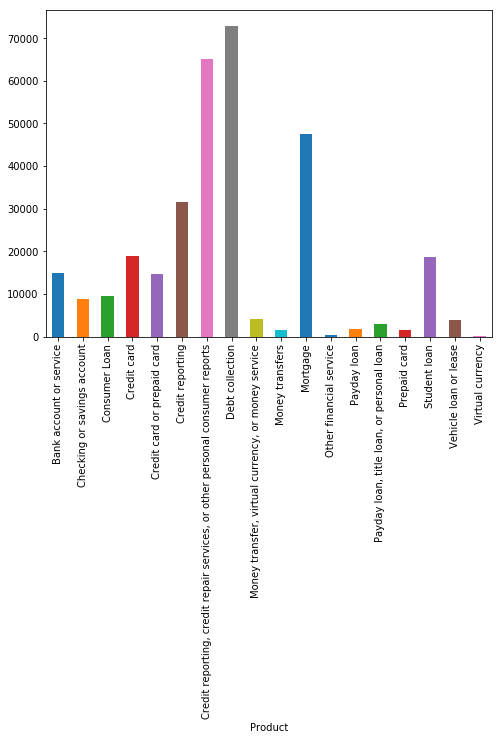

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [5]:
# sublinear_df is set to True to use a logarithmic form for frequency.
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
print(features.shape)

(318718, 628527)


In [6]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. bank
. overdraft
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Checking or savings account':
  . Most correlated unigrams:
. overdraft
. deposit
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. vehicle
. car
  . Most correlated bigrams:
. santander consumer
. auto loan
# 'Credit card':
  . Most correlated unigrams:
. macy
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. equifax
. experian
  . Most correlated bigrams:
. verify accounts
. credit report
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. inquiries
. equifax
  . Most correlated bigrams:
. report underst

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
#Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
#预测
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA.\
                                         I do not believe this debt is mine."])))
    

['Debt collection']


In [9]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification \
and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
5972,Debt collection,This company refuses to provide me verificatio...,5


In [10]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. \
                                         I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items \
                                         that I mentioned in the letter and not all the items that were actually listed on the police report. \
                                         In other words they wanted me to say word for word to them what items were fraudulent. \
                                         The total disregard of the police report and what accounts that it states that are fraudulent. \
                                         If they just had paid a little closer attention to the police report I would not been in this \
                                         position now and they would n't have to research once again. \
                                         I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [11]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. \
I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the \
letter and not all the items that were actually listed on the police report. In other words they wanted me to say \
word for word to them what items were fraudulent. The total disregard of the police report and what accounts that \
it states that are fraudulent. If they just had paid a little closer attention to the police report I would not \
been in this position now and they would n't have to research once again. I would like the reported information \
to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
6268,Credit reporting,I am disputing the inaccurate information the ...,3


## Model Selection ##

We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following four models:

**Logistic Regression**

**(Multinomial) Naive Bayes**

**Linear Support Vector Machine**

**Random Forest**

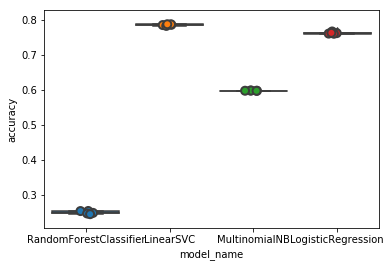

In [12]:

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [13]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.786721
LogisticRegression        0.763528
MultinomialNB             0.598040
RandomForestClassifier    0.248718
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 82%.

**随机森林是一种非常好的，强大而通用的方法，但对于高维稀疏数据来说，它并不是最好的选择。**

**线性支持向量机(SVM),逻辑回归都是不错的选择**

## Model Evaluation ##
Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

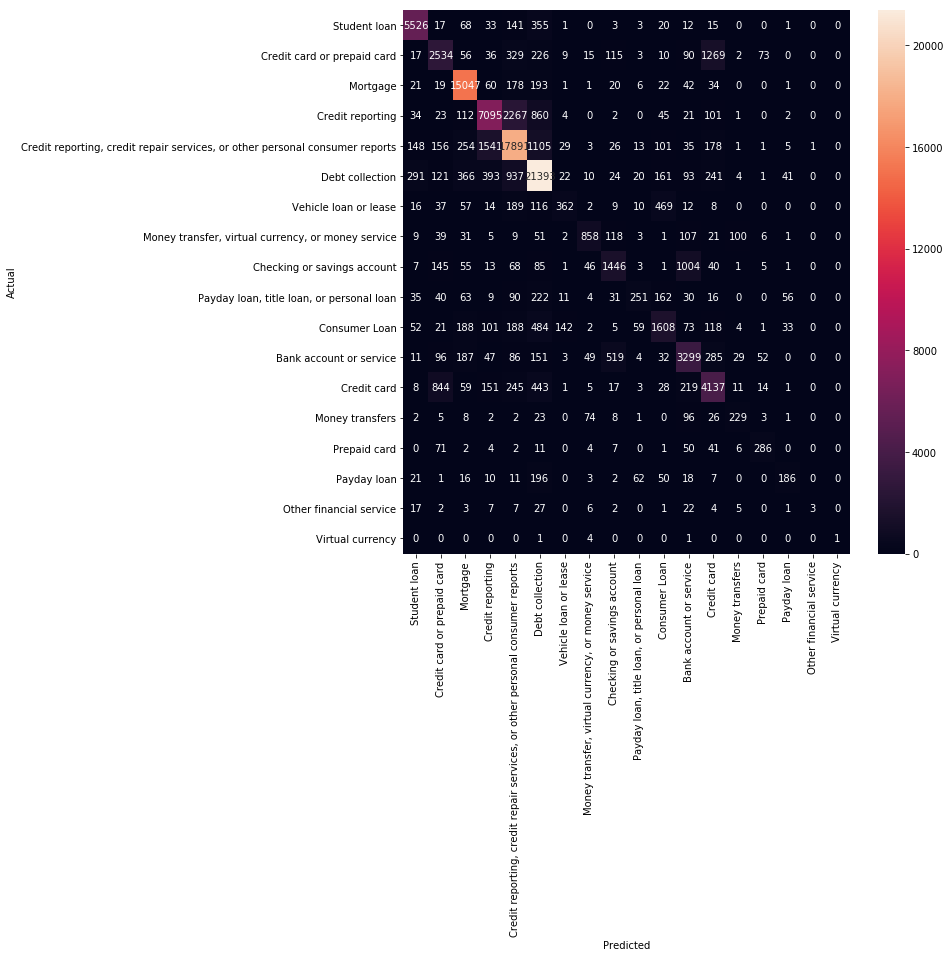

In [22]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Credit card or prepaid card' predicted as 'Student loan' : 17 examples.


,Product,Consumer_complaint_narrative
945647,Credit card or prepaid card,"About a month ago, I requested, via email to X..."
1050708,Credit card or prepaid card,this is as far as what happened XXXX XXXX XXXX...
1022352,Credit card or prepaid card,XX/XX/XXXX interest rate = XXXX XX/XX/XXXX int...
1092822,Credit card or prepaid card,This company ( XXXX XXXX ) is not able or unwi...
713183,Credit card or prepaid card,I have notified target over and over again via...
987316,Credit card or prepaid card,I have tried several different external apps l...
768109,Credit card or prepaid card,"Some time ago, I sent Chase a letter informing..."
1087163,Credit card or prepaid card,I have a loan with XXXX. I have always made my...
935073,Credit card or prepaid card,"Recently on XX/XX/2018, I spoke with a represe..."
1043240,Credit card or prepaid card,First transaction for a balance transfer loan ...



'Mortgage' predicted as 'Student loan' : 21 examples.


,Product,Consumer_complaint_narrative
932102,Mortgage,Since the beginning of 2018 I have been trying...
993093,Mortgage,I have sent a letter to them XXXX XXXX 2017 at...
942973,Mortgage,Bank of America is reporting my balance incorr...
1062998,Mortgage,This company appears to be maximizing interest...
1095314,Mortgage,I was sent a letter stating that I was in defa...
724756,Mortgage,unable to check my balance or any other inform...
298826,Mortgage,new rules permit clients in bankruptcy to rece...
927777,Mortgage,Dealing with this company has been utterly rid...
945070,Mortgage,New loan service agency is demanding that I as...
952786,Mortgage,Our loan was in good standing until it got tra...



'Credit reporting' predicted as 'Student loan' : 34 examples.


,Product,Consumer_complaint_narrative
1066646,Credit reporting,"XX/XX/XXXX, while discussing an unrelated busi..."
977585,Credit reporting,I have had student loans since the age of XXXX...
940877,Credit reporting,Transunion was informed of incorrect reporting...
1093767,Credit reporting,XXXX College had a data breach involving XXXX ...
180167,Credit reporting,Equifax has been reporting a student loan bala...
560895,Credit reporting,My credit damage occurred because of beyond my...
987393,Credit reporting,They will not respond to any of my disputes. \...
229522,Credit reporting,I do not have an account with Sallie Mae. I re...
619565,Credit reporting,2010 I attended an online college called XXXX ...
689260,Credit reporting,I have a written a letter to XXXX Customer Ser...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 148 examples.


,Product,Consumer_complaint_narrative
926581,"Credit reporting, credit repair services, or o...",Navient reported incorrect loan amount on my c...
1016079,"Credit reporting, credit repair services, or o...","Hello, I have always been in good standing wit..."
131178,"Credit reporting, credit repair services, or o...",I contacted Navient Student Loan Service at XX...
98228,"Credit reporting, credit repair services, or o...",I get XXXX students loans showing on my cred...
1004565,"Credit reporting, credit repair services, or o...",Upon being told by the VA that I was no longer...
1011203,"Credit reporting, credit repair services, or o...",I would like to submit a complaint regarding m...
1395,"Credit reporting, credit repair services, or o...",I Sent a letter and legal documents to XXXX re...
941762,"Credit reporting, credit repair services, or o...",I have requested verification of a loan reflec...
1050517,"Credit reporting, credit repair services, or o...",Department of Education and I had a communicat...
716280,"Credit reporting, credit repair services, or o...",At present Navient shows that I have ( 2 ) clo...



'Debt collection' predicted as 'Student loan' : 291 examples.


,Product,Consumer_complaint_narrative
928939,Debt collection,I believe my XXXX XXXX XXXX XXXX XXXX ( XXXX )...
759060,Debt collection,I have been paying from XX/XX/XXXXeach month t...
1047561,Debt collection,I am taking legal action against National Coll...
700806,Debt collection,XX/XX/2018 ~XXXXXXXX ( est ) I received a call...
1047259,Debt collection,"FMS ( XXXX, NC ) appears to be trying to pull ..."
318135,Debt collection,Entered 12 month student loan recovery program...
719773,Debt collection,For the same loan that you had resolved for me...
933208,Debt collection,"Hello, My name is XXXX XXXX, my address is XXX..."
163099,Debt collection,I am an XXXX at XXXX XXXX XXXX XXXX...
1030881,Debt collection,I have a loan with Navient and had been placed...



'Vehicle loan or lease' predicted as 'Student loan' : 16 examples.


,Product,Consumer_complaint_narrative
279603,Vehicle loan or lease,"Received an email today, Saturday XXXX/XXXX/XX..."
1017651,Vehicle loan or lease,I have a loan with XXXX. I have always made my...
345356,Vehicle loan or lease,"Twice, this company has marked my account as ""..."
1092356,Vehicle loan or lease,I had requested lower payments over a longer t...
783187,Vehicle loan or lease,Bank is telling back in XX/XX/XXXX that they d...
922440,Vehicle loan or lease,"In 2017, I leased a car for XXXX. I am current..."
937752,Vehicle loan or lease,On XX/XX/XXXX my Vehicle was repossessed by 5/...
993923,Vehicle loan or lease,I co-signed an auto loan for my daughter. The ...
266761,Vehicle loan or lease,XX/XX/XXXX XX/XX/XXXX tried to pay back the lo...
1079625,Vehicle loan or lease,XXXX XXXX reorganized in XXXX for financial re...



'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 35 examples.


,Product,Consumer_complaint_narrative
495336,"Payday loan, title loan, or personal loan",I borrowed money from XXXX XXXX XXXX several ...
1001549,"Payday loan, title loan, or personal loan",I got a loan with them initially the pay off a...
690644,"Payday loan, title loan, or personal loan",I received an email for a loan over the intern...
959924,"Payday loan, title loan, or personal loan",I already have an account with one main. I was...
955775,"Payday loan, title loan, or personal loan",I took out a student loan with Navient. There ...
1072279,"Payday loan, title loan, or personal loan","On XXXX , I signed a contract with XXXX XX..."
994854,"Payday loan, title loan, or personal loan",We Are not able to make payments to the Princi...
270473,"Payday loan, title loan, or personal loan",XX/2016 took a XXXX dollar loan toake ends mee...
333004,"Payday loan, title loan, or personal loan",Nelnet Refuses To Mail Me A Paid In Full Lette...
1429,"Payday loan, title loan, or personal loan",I was applying for an installment loan online ...



'Consumer Loan' predicted as 'Student loan' : 52 examples.


,Product,Consumer_complaint_narrative
1077812,Consumer Loan,the lender was very good at giving the loan ou...
609666,Consumer Loan,I 'm unable to make the large biweekly payment...
667742,Consumer Loan,I took out a personal loan from XXXX XXXX when...
1106214,Consumer Loan,The loan company keep increasing my loan limit...
723177,Consumer Loan,"The loan, after several years of servicing, wa..."
216618,Consumer Loan,My auto loan service provider refuses to follo...
967376,Consumer Loan,I have a student loan through Great Lakes. The...
65590,Consumer Loan,There is a large discrepancy between what I am...
950480,Consumer Loan,My wife and I have had a loan wit XXXX XXXX fo...
956484,Consumer Loan,Applied for loan with Circleback Lending - aft...



'Bank account or service' predicted as 'Student loan' : 11 examples.


,Product,Consumer_complaint_narrative
1073428,Bank account or service,"For my non-qualified pension, in 2014 Wells Fa..."
261593,Bank account or service,I have CDs with Sallie Mae Bank. XXXX CD matur...
934309,Bank account or service,I have set up through Bank of America an autom...
354858,Bank account or service,We have a loan with Umqua bank. They automatic...
965216,Bank account or service,"In XXXX of XXXX, I took out XXXX business loan..."
964559,Bank account or service,I contacted a representative of Key Bank about...
927052,Bank account or service,"Upromise, who is owned by Sallie Mae provides ..."
730902,Bank account or service,I had to wait 20 minutes ( on hold ) just to g...
1029067,Bank account or service,There is an old student loan that I have been ...
1057024,Bank account or service,I have been adding extra money to my auto mont...



'Payday loan' predicted as 'Student loan' : 21 examples.


,Product,Consumer_complaint_narrative
963188,Payday loan,The interest is 782 % they already in one mont...
1107003,Payday loan,I am getting collection calls regarding XXXX l...
1099088,Payday loan,"I took out a XXXX loan in XXXX 2015, they were..."
1066535,Payday loan,I all ready paid XXXX in interest and the loan...
1068611,Payday loan,"I borrowed XXXX in 2012, I have already paid b..."
614449,Payday loan,They denied me the ability to pay the loan off...
691121,Payday loan,Lender contacts for payment BEFORE the loan pa...
1024002,Payday loan,I 've tried contacting the lender to resolve t...
259965,Payday loan,I had a loan for XXXX which interest will XXXX...
722597,Payday loan,I received a loan and could not repay from Zes...



'Other financial service' predicted as 'Student loan' : 17 examples.


,Product,Consumer_complaint_narrative
981894,Other financial service,I entered into an Agreement with Student Loan ...
328355,Other financial service,I received an email from representatives from ...
976301,Other financial service,I saw an ad on Facebook that a friend posted s...
781191,Other financial service,I called a number that I found when I searched...
200400,Other financial service,I attempted to contact Navient to discuss my s...
922034,Other financial service,I have recently hired a company who claimed to...
1072139,Other financial service,I was contacted by fedloan and told they could...
343591,Other financial service,I was contacted as soon as I graduated in XXXX...
949452,Other financial service,I enrolled in National Budget Planners of Sout...
977141,Other financial service,I hired the company The Student Loan Help Cent...



'Student loan' predicted as 'Credit card or prepaid card' : 17 examples.


,Product,Consumer_complaint_narrative
39592,Student loan,Around XX/XX/XXXX my husband had to take a pay...
941149,Student loan,"I was charged a {$6.00} "" late fee '' for the ..."
21982,Student loan,"After numerous harassing calls, I have decided..."
441714,Student loan,I have a loan with ED FINANCIALXXXX. I have al...
1052836,Student loan,I had XXXX for my previous loan servicer and w...
187718,Student loan,Attempted to enroll in auto payment to pay the...
533219,Student loan,I was shocked when I reviewed my credit report...
967068,Student loan,Late payments that should not be on my credit ...
968600,Student loan,-they falsified my application ( family size ...
244166,Student loan,I am a US citizen but no longer live in the U...



'Mortgage' predicted as 'Credit card or prepaid card' : 19 examples.


,Product,Consumer_complaint_narrative
1095689,Mortgage,WELLS FARGO DISPUTE 15 U.S. Code Subchapter I ...
995445,Mortgage,In XX/XX/XXXX I attempted to refinance my line...
1039809,Mortgage,I was trying to pay XXXX XX/XX/XXXX to get cau...
66664,Mortgage,There is a FULL month going back and forth wit...
733371,Mortgage,My home was impacted by hurricane XXXX.I calle...
1061863,Mortgage,"XXXX I have sent the same below to XXXX ,..."
938689,Mortgage,On XX/XX/XXXX I submitted complaint # XXXX aga...
962228,Mortgage,they lost my XX/XX/XXXX payment. I authorized ...
549658,Mortgage,"I filed Chapter XXXX bankruptcy in XX/XX/XXXX,..."
580561,Mortgage,I am trying to pay with my XXXX credit card an...



'Credit reporting' predicted as 'Credit card or prepaid card' : 23 examples.


,Product,Consumer_complaint_narrative
945124,Credit reporting,I was notified of the a XXXX rewards card open...
985511,Credit reporting,Account showing as missed payment but account ...
987010,Credit reporting,I have also made several attempts to have my n...
1010077,Credit reporting,"The credit card is a business credit card, but..."
1076425,Credit reporting,Equifax is now in violation due to the failure...
614231,Credit reporting,I recently learned from a collection agency ( ...
206503,Credit reporting,"very "" simple '' situation. XXXX XXXX refused ..."
1079661,Credit reporting,I closed all my accounts and credit cards with...
978256,Credit reporting,My account shows an address that I have never ...
1017302,Credit reporting,I am very concern as I was checking my credit...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 156 examples.


,Product,Consumer_complaint_narrative
1030523,"Credit reporting, credit repair services, or o...",On XX/XX/2018 Chase Bank indicated i made an i...
236809,"Credit reporting, credit repair services, or o...",Since XX/XX/XXXX of XX/XX/XXXX I was attemptin...
18452,"Credit reporting, credit repair services, or o...",By the amount of {$3400.00} dollars my credit ...
987379,"Credit reporting, credit repair services, or o...",My payments are every XXXX of the month. I mad...
968029,"Credit reporting, credit repair services, or o...",Account ending in # XXXX was closed w/ XXXX ba...
941746,"Credit reporting, credit repair services, or o...","Under CFPB case XXXX , Synchrony Bank informe..."
596229,"Credit reporting, credit repair services, or o...",I am using an app to predict future XXXX XXXX ...
931364,"Credit reporting, credit repair services, or o...",I was anticipating my enrollment in a credit c...
374007,"Credit reporting, credit repair services, or o...","I am the daughter of XXXX XXXX XXXX, an XXXX X..."
932058,"Credit reporting, credit repair services, or o...",I went in for procedures to be done and they w...



'Debt collection' predicted as 'Credit card or prepaid card' : 121 examples.


,Product,Consumer_complaint_narrative
1011094,Debt collection,I am a XXXX in the XXXX XXXX XXXX XXXX. My XXX...
922890,Debt collection,capital onecredit card threatened me when I to...
1014124,Debt collection,This credit card was issued thru MBNA and was ...
1077554,Debt collection,On XX/XX/XXXX I applied for a credit card onli...
740510,Debt collection,I was contacted by Goldman Sachs Bank USA last...
996017,Debt collection,"I am trying to pay this debt howe ver, Citi/AT..."
1010437,Debt collection,XXXX XXXX collection company says that I owe t...
561953,Debt collection,I got a credit card from the XXXX and XXXX XXX...
696820,Debt collection,On XXXX XXXX ; a Written Contract was signed b...
1084173,Debt collection,XX/XX/XXXX MIDLANDMCM I HAVE NO IDEA WHAT THIS...



'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 37 examples.


,Product,Consumer_complaint_narrative
245365,Vehicle loan or lease,XX/XX/XXXX - Vehicle purchased from XXXX XXXX ...
309055,Vehicle loan or lease,On XX/XX/XXXX I spoke with a representative at...
995544,Vehicle loan or lease,I was shocked when I reviewed my credit report...
609719,Vehicle loan or lease,I have had an auto loan with Capital One for 5...
278474,Vehicle loan or lease,"On XXXX XXXX , 2017 the company received ..."
731984,Vehicle loan or lease,On XX/XX/XXXX I was released from my employer....
1060733,Vehicle loan or lease,I have a loan with PENTAGON FCU. I have always...
678513,Vehicle loan or lease,"After paying off my loan, an overpayment was m..."
644025,Vehicle loan or lease,I have a loan with NAVY FCU. I have always mad...
638729,Vehicle loan or lease,I was shocked when I reviewed my credit report...



'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 39 examples.


,Product,Consumer_complaint_narrative
1005456,"Money transfer, virtual currency, or money ser...",Im trying to access my Capital One accounts wi...
75589,"Money transfer, virtual currency, or money ser...",On XX/XX/18 I received a unexpected transfer i...
1072749,"Money transfer, virtual currency, or money ser...",XXXX XXXX applied a {$20.00} credit to my acco...
1065376,"Money transfer, virtual currency, or money ser...",on XX/XX/XXXX I used the XXXX app to pay a mer...
761535,"Money transfer, virtual currency, or money ser...",On XXXX XXXX 2017 - I went to Union ...
1035198,"Money transfer, virtual currency, or money ser...","Petition Dear Lord, Please help us, with these..."
1008412,"Money transfer, virtual currency, or money ser...",I am trying to use XXXX XXXX with the card tha...
520996,"Money transfer, virtual currency, or money ser...",Hello my name is XXXX XXXX. I purchased a mone...
1083175,"Money transfer, virtual currency, or money ser...","I had a XXXX XXXX in XXXX, NC called XXXX XXXX..."
1101292,"Money transfer, virtual currency, or money ser...",This complaint is a concern with using my Goog...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 145 examples.


,Product,Consumer_complaint_narrative
78170,Checking or savings account,On X/XX/17 I checked my checking account and s...
713141,Checking or savings account,A check was written for my rent on XX/XX/XXXX....
1026338,Checking or savings account,Please add this information to [ Case number :...
480595,Checking or savings account,My account through Money network was fraudulen...
113879,Checking or savings account,I opened my credit account in XXXX with the te...
1080038,Checking or savings account,Last day I used card was Saturday XX/XX/XXXX20...
1011881,Checking or savings account,I have several accounts with Navy Federal Cred...
649071,Checking or savings account,Well? It seems like American Express Bluebird ...
931638,Checking or savings account,Last summer ( XX/XX/2017 ) I reported my debit...
978889,Checking or savings account,Capital One Had issued a check for closing the...



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 40 examples.


,Product,Consumer_complaint_narrative
50867,"Payday loan, title loan, or personal loan",my identity was stolen in XXXX 2017. Someone u...
1036322,"Payday loan, title loan, or personal loan",Suntrust issued two lines of credit using my i...
991964,"Payday loan, title loan, or personal loan","On aboutXX/XX/2018, monies were electronically..."
206611,"Payday loan, title loan, or personal loan",In XXXX I was attempting to paid off my acco...
143616,"Payday loan, title loan, or personal loan",I have had accounts opened in my name with ban...
633967,"Payday loan, title loan, or personal loan","On XX/XX/2018, {$1200.00} was taken from my ac..."
688147,"Payday loan, title loan, or personal loan",i contact upgrade today XX/XX/XXXX XXXX about ...
1024367,"Payday loan, title loan, or personal loan","I 've tried to setup automatic three times, on..."
1055079,"Payday loan, title loan, or personal loan",I sent correspondence to the company on XX/XX/...
997575,"Payday loan, title loan, or personal loan",for the past week I have been attempting to ei...



'Consumer Loan' predicted as 'Credit card or prepaid card' : 21 examples.


,Product,Consumer_complaint_narrative
336816,Consumer Loan,I have an auto loan with USAA. The funds are e...
926474,Consumer Loan,I walked into a Kay Jewelers to purchase a gif...
153394,Consumer Loan,On Tuesday XXXX XXXX I called an XXXX with a c...
958855,Consumer Loan,Last XXXX XXXX I applied for a credit line to ...
930117,Consumer Loan,Capital One took an unauthorized payment from ...
997543,Consumer Loan,This payment is set up to auto pay by my credi...
1073002,Consumer Loan,I was shopping for an elliptical and a co-work...
1091016,Consumer Loan,"As a Wells Fargo checking, savings and auto lo..."
1100753,Consumer Loan,On XX/XX/XXXX I bought {$4100.00} of Furniture...
1073700,Consumer Loan,I have attempted to dispute a transaction beca...



'Bank account or service' predicted as 'Credit card or prepaid card' : 96 examples.


,Product,Consumer_complaint_narrative
684003,Bank account or service,Failure to address fraudulent charges and mult...
1011978,Bank account or service,Bank of America has been illegally disposing o...
1099584,Bank account or service,BOA has not closed my account after multiple r...
1080539,Bank account or service,I 've been a customer of Bank of America for m...
197132,Bank account or service,XX/XX/XXXX - I performed a cash load of {$2500...
1040416,Bank account or service,On XXXX/XXXX/XXXX I contacted Chase Bank and i...
695742,Bank account or service,"A bank teller, XXXX XXXX, at the SunTrust Bank..."
1068894,Bank account or service,I have three promotional offer accounts with S...
965412,Bank account or service,I believe that I was charged or enrolled in Wa...
1046092,Bank account or service,"Synchrony Bank : deceptive business practices,..."



'Credit card' predicted as 'Credit card or prepaid card' : 844 examples.


,Product,Consumer_complaint_narrative
999273,Credit card,CITI BANK is charging me late fees without sen...
708441,Credit card,I was moving and made a purchase of XXXX for a...
1033577,Credit card,I recently made a payment on a Citbank card th...
993283,Credit card,I entered into a contract with a kitchen co. t...
1026675,Credit card,I bought something with my credit card from a ...
650860,Credit card,Around the first week of XXXX I tried using XX...
1070201,Credit card,I have a credit card with Home Depot. Home Dep...
1013047,Credit card,What happened is there was a authorize on my a...
459701,Credit card,"Hello, I recently noticed my BB & T Spectrum r..."
1021694,Credit card,I have been a Bank of America credit card cust...



'Prepaid card' predicted as 'Credit card or prepaid card' : 71 examples.


,Product,Consumer_complaint_narrative
1061295,Prepaid card,I purchased a prepaid Serve American Express a...
978114,Prepaid card,"On XXXX XXXX, my Bluebird American Express acc..."
1010262,Prepaid card,On XXXX XXXX I tried to log into my Ameri...
992323,Prepaid card,I have not been able to access my account acce...
391631,Prepaid card,I purchased a {$500.00} prepaid XXXX gift card...
982885,Prepaid card,I was given a {$40.00} prepaid card from NetSp...
923869,Prepaid card,I prepared my XX/XX/XXXX income tax online. Th...
617866,Prepaid card,Received unsolicited pre-paid debit card. \n\n...
669261,Prepaid card,I have a {$100.00} Visa gift card I was saving...
225585,Prepaid card,I opened an account for a prepaid Visa card wi...



'Student loan' predicted as 'Mortgage' : 68 examples.


,Product,Consumer_complaint_narrative
1100811,Student loan,Became XXXX and could n't repay. Due to a rule...
52647,Student loan,My monthly payments were applied late. Therefo...
489610,Student loan,"XX/XX/XXXX, I submitted an application to refi..."
232870,Student loan,On XXXX/XXXX/2015 I filed a complaint with CFP...
303364,Student loan,Excess payments are applied toward future paym...
1084259,Student loan,Higher interest rate charged than originally t...
981936,Student loan,"Wells Fargo & Company, has refused to provide ..."
922948,Student loan,I began paying for my loan with Wells Fargo th...
996355,Student loan,I have scheduled automatic payments. The payme...
1067705,Student loan,Please see related complaint # XXXX. While I a...



'Credit card or prepaid card' predicted as 'Mortgage' : 56 examples.


,Product,Consumer_complaint_narrative
966855,Credit card or prepaid card,"On XXXX XXXX , XXXX two days before y c..."
1108314,Credit card or prepaid card,In response to : XXXX I went into my local bra...
997771,Credit card or prepaid card,The late payments reported by Key Bank to the...
994133,Credit card or prepaid card,"Sometime in XX/XX/XXXX, a friend had gutters p..."
1000377,Credit card or prepaid card,XXXX added a 30 day late negative to my credit...
1089794,Credit card or prepaid card,XXXX We contacted Capital One about the accoun...
659275,Credit card or prepaid card,Around XX/XX/2007 my wife XXXX XXXX and I appl...
247816,Credit card or prepaid card,Bank of America has both admitted fault in the...
747671,Credit card or prepaid card,A recent adjustment was made on my account and...
1036000,Credit card or prepaid card,"XXXX XXXX XXXX XXXX ( XXXX ), XXXX XXXX XXXX X..."



'Credit reporting' predicted as 'Mortgage' : 112 examples.


,Product,Consumer_complaint_narrative
601287,Credit reporting,My mortgage was sold to XXXX. XXXX failed to p...
316498,Credit reporting,My home mortgage bank dose not report every pa...
691349,Credit reporting,I had a mortgage with XXXX XXXX XXXX that was ...
1024540,Credit reporting,XXXX XXXX XXXX has posted a collection account...
219603,Credit reporting,Experian is reporting a Foreclosed mortgage. T...
1002612,Credit reporting,XX/XX/2015 I closed on a home using a conventi...
975270,Credit reporting,I had a mortgage loan that was foreclosed on i...
997773,Credit reporting,"I 'm am trying to clean up my credit, during t..."
980327,Credit reporting,"My daughter XXXX XXXX, that is with me in the ..."
127312,Credit reporting,A settlement for a short sale with XXXX was ma...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 254 examples.


,Product,Consumer_complaint_narrative
937383,"Credit reporting, credit repair services, or o...",In XX/XX/XXXXI 've experience some water damag...
948055,"Credit reporting, credit repair services, or o...","On XXXX 2015 and XXXX 2015, I paid my mortgage..."
89045,"Credit reporting, credit repair services, or o...",Original mortgage was with America 's Servicin...
687154,"Credit reporting, credit repair services, or o...",Memo to CFPB To Whom It Concerns : I am writin...
1039604,"Credit reporting, credit repair services, or o...",Chase is reporting on XXXX a last reported dat...
756973,"Credit reporting, credit repair services, or o...",I am in a FEMA declared disaster area from Hur...
933849,"Credit reporting, credit repair services, or o...",Back in XX/XX/XXXX we started having financial...
973680,"Credit reporting, credit repair services, or o...","We set up a payment plan, signed XXXX/XXXX/XXX..."
1022985,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX ( XXXX ) , XXXX X..."
188477,"Credit reporting, credit repair services, or o...","In XX/XX/XXXX, I filed a dispute with all thre..."



'Debt collection' predicted as 'Mortgage' : 366 examples.


,Product,Consumer_complaint_narrative
535863,Debt collection,Carrington Mortgage has reported that I was la...
1089682,Debt collection,In XX/XX/XXXX I had to obtain an attorney to h...
1021922,Debt collection,I had a loan that was sold to a different mort...
413354,Debt collection,Cancellation of Debt Form XXXX for {$30000.00}...
1031031,Debt collection,I am being sued for a mortgage that was improp...
1023788,Debt collection,This Affidavit and Notice of Complaint is bein...
997189,Debt collection,they call insisting need to call today call at...
1108004,Debt collection,XXXX XXXX is listed as a petitioner for the XX...
1018028,Debt collection,I submitted this complaint for a wrongful evic...
1086914,Debt collection,I contacted Freedom Mortgage in XXXX many time...



'Vehicle loan or lease' predicted as 'Mortgage' : 57 examples.


,Product,Consumer_complaint_narrative
519583,Vehicle loan or lease,Complaint number : XXXX This has not been re...
953374,Vehicle loan or lease,The loan company refuses to accept my payments...
344653,Vehicle loan or lease,I made all of the payments required on the loa...
452717,Vehicle loan or lease,DISCRIMINATION Plaintiff : Company : XXXX XXXX...
1111467,Vehicle loan or lease,state farm bank-I mailed them principal only p...
1001169,Vehicle loan or lease,"On XXXX XXXX , XXXX at XXXX XXXX ...."
1005753,Vehicle loan or lease,I CONTACTED BANK OF THE WEST IN XX/XX/XXXX TO ...
274723,Vehicle loan or lease,My Bank of America Auto ( BOA ) Loan account #...
1110068,Vehicle loan or lease,I purchased a XXXX XXXX XXXX Certified preowne...
974029,Vehicle loan or lease,"Reached out to lender, no action taken, no res..."



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 31 examples.


,Product,Consumer_complaint_narrative
1012502,"Money transfer, virtual currency, or money ser...","This is not a debt collection issue, I chose t..."
662204,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I contacted USBank to discuss p..."
1032544,"Money transfer, virtual currency, or money ser...",I have a brokerage account with XXXX XXXX. The...
1047419,"Money transfer, virtual currency, or money ser...",MB financial is not updating my information wi...
634136,"Money transfer, virtual currency, or money ser...",XXXX XXXX XXXX XXXXXXXX sent me a check for XX...
1069144,"Money transfer, virtual currency, or money ser...",BANKS OF NORTH CAROLINA N C General statute a...
963130,"Money transfer, virtual currency, or money ser...",I XXXX from XXXX XXXX XXXX where I...
987735,"Money transfer, virtual currency, or money ser...",I applied for and received a mortgage through ...
1059205,"Money transfer, virtual currency, or money ser...",In association with the following cases : cfpb...
251496,"Money transfer, virtual currency, or money ser...",Family suffered complete loss of home. Insuran...



'Checking or savings account' predicted as 'Mortgage' : 55 examples.


,Product,Consumer_complaint_narrative
737299,Checking or savings account,The personnel at Wells Fargo know me very well...
674081,Checking or savings account,I am filing a complaint against TD Bank. I mai...
13982,Checking or savings account,I have been trying to close my father 's accou...
1096450,Checking or savings account,The complaint involves : 1. An initial denial ...
774566,Checking or savings account,I had a Home Equity Line balance with this lan...
949136,Checking or savings account,"In XXXX, my parents purchased a savings certif..."
615335,Checking or savings account,My name is XXXX XXXX and I am a XXXX XXXX with...
22965,Checking or savings account,I discovered XXXX checks from my ESCROW OVERAG...
952192,Checking or savings account,Submitted complaint XXXX. Company responded wi...
221748,Checking or savings account,We were told onXX/XX/XXXX we were approved for...



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 63 examples.


,Product,Consumer_complaint_narrative
930632,"Payday loan, title loan, or personal loan",Got the loan through XXXX another company boug...
1043336,"Payday loan, title loan, or personal loan","In XXXX , Beneficial added more debt- They ju..."
77689,"Payday loan, title loan, or personal loan",I obtained a loan from XXXX towards the end of...
1098583,"Payday loan, title loan, or personal loan","I hope this is not a scam, since I just signed..."
467111,"Payday loan, title loan, or personal loan",The company is scamming people out of their in...
956809,"Payday loan, title loan, or personal loan","I have a mortgage with Wells Fargo since 1996,..."
1007552,"Payday loan, title loan, or personal loan",I inquired online about a debt consolidation l...
565880,"Payday loan, title loan, or personal loan",XX/XX/2018 I am complaining about the service ...
958384,"Payday loan, title loan, or personal loan",This is in reference to a previous complaint #...
286784,"Payday loan, title loan, or personal loan",XXXX XXXX XXXX. XX/XX/2016 {$2400.00} to prese...



'Consumer Loan' predicted as 'Mortgage' : 188 examples.


,Product,Consumer_complaint_narrative
1015456,Consumer Loan,I have a loan with BMW Bank of North America f...
947929,Consumer Loan,My wife and I have had this loan for a number ...
767306,Consumer Loan,XXXX XXXX claimed he worked for BB & T said I ...
701990,Consumer Loan,"Bi Weekly payments of {$180.00}, i notified th..."
964642,Consumer Loan,Again have n't answered my question.. \nAre yo...
1063228,Consumer Loan,I made all monthly installments along with any...
1066645,Consumer Loan,We have an auto loan and mortgage with Chase B...
660870,Consumer Loan,"This occurred at the Huntington Bank/XXXX, Ohi..."
967189,Consumer Loan,XXXX and Wells Fargo repeatedly attempted to c...
946249,Consumer Loan,EX SPOUSE WAS ABLE TO OBTAIN A LOAN IN THE AMO...



'Bank account or service' predicted as 'Mortgage' : 187 examples.


,Product,Consumer_complaint_narrative
331468,Bank account or service,I 've been making the mortgage payments ( Chas...
13734,Bank account or service,My wife and I applied for a Home Equity Line o...
1090241,Bank account or service,"Suntrust closed my checking account, due to in..."
1065353,Bank account or service,My loan was recently transferred to Nationstar...
809052,Bank account or service,"On XXXX XXXX, 2016 I wrote a check to Wells Fa..."
1107350,Bank account or service,My husband and I paid off our personal line of...
118474,Bank account or service,Wells Fargo Bank initiated predatory Lending o...
1113371,Bank account or service,Bank of America received funds from insurance ...
779191,Bank account or service,We have a second mortgage with Wells Fargo. Be...
980303,Bank account or service,I signed up for Nationwide Biweekly in XX/XX/2...



'Credit card' predicted as 'Mortgage' : 59 examples.


,Product,Consumer_complaint_narrative
991640,Credit card,"A Man XXXX called, XXXX XXXX XXXX XXXX XXXX ....."
230385,Credit card,I applied For a Chase XXXX Rewards Card on...
1029244,Credit card,Capital One bank took money out of my account ...
471919,Credit card,Made a payment of XXXX on XXXX to Bank of Amer...
930904,Credit card,This is a follow-up complaint to several other...
935961,Credit card,The company name on the contract is ; XXXX XXX...
1050728,Credit card,I disputed a charge XXXX in the amount of XXXX...
365784,Credit card,I accidently sent a {$1000.00}. payment to Cha...
974903,Credit card,A property has an insurance for flood that is ...
99583,Credit card,I have XXXX separate credit cards that were wi...



'Payday loan' predicted as 'Mortgage' : 16 examples.


,Product,Consumer_complaint_narrative
707771,Payday loan,I was in the process of applying for a payday ...
1043191,Payday loan,I had a balance of {$100.00} and I refinanced ...
568587,Payday loan,"Lender contact info is no longer working, both..."
991878,Payday loan,I applayed for Loan on internet the amount I a...
965310,Payday loan,Lender is not updating my loan status in the V...
710572,Payday loan,1 - I am being asked to pay XXXX a month that ...
396022,Payday loan,I have a loan with Check N Go. The loan is now...
1048736,Payday loan,I received an email Check n Go denying a loan ...
696192,Payday loan,In XXXX my husband got a probate cash advance ...
1083143,Payday loan,I feel am being over charged. I had made payme...



'Student loan' predicted as 'Credit reporting' : 33 examples.


,Product,Consumer_complaint_narrative
1088151,Student loan,"I had a loan through XXXX student loan, and th..."
693371,Student loan,Please see enclosed letter for detailed inform...
210109,Student loan,NELNET is reporting student loan late payments...
979583,Student loan,Would like a XXXX or less Per month payment
1022553,Student loan,I have filed my complain previously to CFPB ( ...
939753,Student loan,"XXXX XXXX, 2015 I was told i could get my loan..."
1074164,Student loan,XXXX is reporting XXXX accounts with XXXX miss...
1072067,Student loan,This is a paid account with XXXX balance. The ...
441898,Student loan,XXXX is not reporting payments made to my Stud...
1094689,Student loan,"XXXX loans were closed and moved to XXXX, on X..."



'Credit card or prepaid card' predicted as 'Credit reporting' : 36 examples.


,Product,Consumer_complaint_narrative
476251,Credit card or prepaid card,I 've had a XXXX card for 5 years and XXXX aud...
582926,Credit card or prepaid card,I 'm seeing a hard inquiry by Cbna on my credi...
922701,Credit card or prepaid card,"Hi, This is XXXX XXXX XXXX. I want let you kno..."
303355,Credit card or prepaid card,Discover Credit card After continuously disput...
308041,Credit card or prepaid card,XXXX continues to report an account to my cred...
1025844,Credit card or prepaid card,I tried to close my account and they told me t...
750375,Credit card or prepaid card,This is a fraudulent card opened in my name. I...
360150,Credit card or prepaid card,Company switched me to paperless billing. I di...
1080276,Credit card or prepaid card,Ca n't close account.
1038855,Credit card or prepaid card,"A XXXX XXXX "" the Bank '' credit card was open..."



'Mortgage' predicted as 'Credit reporting' : 60 examples.


,Product,Consumer_complaint_narrative
710559,Mortgage,I have tried contacting People 's Bank on XXXX...
955053,Mortgage,My mortgage company refuses to report any of m...
700986,Mortgage,My monthly payments have not been on here sinc...
80004,Mortgage,Here 's the documentation you requested. As I ...
1024479,Mortgage,XXXX XXXX XXXX XXXX Va XXXX Dob XXXX/XXXX/XXXX...
964371,Mortgage,My credit report is showing a late payment fro...
937281,Mortgage,I had a short sale back in 2009 which was nego...
1009892,Mortgage,I asked XXXX to investigate my dispute with XX...
926391,Mortgage,"In 2014, I went to XXXX in order to buy a mobi..."
667660,Mortgage,Bank of American is actively reporting foreclo...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 1541 examples.


,Product,Consumer_complaint_narrative
371197,"Credit reporting, credit repair services, or o...",Currently a discharged bankruptcy is being rep...
1008879,"Credit reporting, credit repair services, or o...",I have written a letter to Experian dated XX/X...
451300,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX - Disputes were sent on to Trans...
1040815,"Credit reporting, credit repair services, or o...",TransUnion reported to a store application sta...
991873,"Credit reporting, credit repair services, or o...",My name is XXXX XXXX XXXX and my address is XX...
1049665,"Credit reporting, credit repair services, or o...",I am attempting to get my Experian annual free...
945244,"Credit reporting, credit repair services, or o...",Equifax is refusing to remov e two XXXX XX...
1090489,"Credit reporting, credit repair services, or o...",I received an alert about inquiries on my cred...
1008189,"Credit reporting, credit repair services, or o...",I am in the m iddle of repairing my credit and...
504122,"Credit reporting, credit repair services, or o...",Once again the criminally negligent XXXX at on...



'Debt collection' predicted as 'Credit reporting' : 393 examples.


,Product,Consumer_complaint_narrative
551650,Debt collection,I lost My Social Security And report to police...
1030086,Debt collection,Experian is reporting a debt for XXXX XXXX XXX...
961138,Debt collection,XXXX refuses to get bill off my credit. I have...
1079163,Debt collection,There is an account reporting on my credit rep...
945328,Debt collection,Credit Acceptance has continued to try and col...
497449,Debt collection,They have doubled the amount by filing it twic...
972736,Debt collection,Citibank is still reporting inaccurate informa...
1025639,Debt collection,My credit report has an error. XXXX XXXX repor...
926604,Debt collection,"My credit record shows a charge due to XXXX, w..."
947455,Debt collection,"In XXXX on XXXX XXXX, we were evicted from our..."



'Vehicle loan or lease' predicted as 'Credit reporting' : 14 examples.


,Product,Consumer_complaint_narrative
966198,Vehicle loan or lease,This is an identity theft account that o have ...
1059315,Vehicle loan or lease,I off Bridge crest need it to be report to XXX...
980629,Vehicle loan or lease,This is not my account.
1063496,Vehicle loan or lease,I need every inquiry removed i see a lot that ...
991357,Vehicle loan or lease,This is not my account.
684284,Vehicle loan or lease,"on XXXX XXXX, XXXX I faxed CHRYSLER CAPITAL as..."
536127,Vehicle loan or lease,I have a Santandar charge off on my credit rep...
747946,Vehicle loan or lease,Greetings : I have been paying Wells Fargo Dea...
504374,Vehicle loan or lease,I made payment arrangements with AutoTrakk and...
179554,Vehicle loan or lease,I was told I could change the date of my loan ...



'Checking or savings account' predicted as 'Credit reporting' : 13 examples.


,Product,Consumer_complaint_narrative
1055519,Checking or savings account,I 've recently learned from XXXX that my credi...
91417,Checking or savings account,I was refused access to my online account beca...
413137,Checking or savings account,Vanguard will not release information on an a...
1102331,Checking or savings account,Will not allow third party site to access account
535482,Checking or savings account,Wrong banking info
936133,Checking or savings account,My wife and I opened a new checking bank accou...
1033643,Checking or savings account,I am trying to verify my account information t...
1082585,Checking or savings account,I have paid an account that was closed due to ...
629607,Checking or savings account,In XX/XX/XXXX I was involved in an internet sc...
5825,Checking or savings account,The company XXXX is n't getting the informat...



'Consumer Loan' predicted as 'Credit reporting' : 101 examples.


,Product,Consumer_complaint_narrative
1018885,Consumer Loan,Lender reported to credit bureaus that my XXXX...
584792,Consumer Loan,Equifax credit reporting need to remove the Ba...
340763,Consumer Loan,I never signed nor endorsed any contract or ap...
681106,Consumer Loan,"In XXXX of 2014, I tried an XXXX XXXX XXXX and..."
1008227,Consumer Loan,"It was brought to my attention that a "" Negati..."
991140,Consumer Loan,I filed a complaint with AHFC due to late noti...
983896,Consumer Loan,I opened a joint auto loan accountwith Wells F...
998709,Consumer Loan,Microbilt pulled my credit report on XX/XX/201...
526103,Consumer Loan,I took out a loan with instaloan around the en...
995774,Consumer Loan,"In XXXX 2015, I disputed an auto loan with Fir..."



'Bank account or service' predicted as 'Credit reporting' : 47 examples.


,Product,Consumer_complaint_narrative
1075222,Bank account or service,Initially in XXXX XXXX i was notified of XXXX ...
247128,Bank account or service,Money withdrawn from my savings account in the...
500092,Bank account or service,I have been trying to communicate with Wells F...
240550,Bank account or service,THERE ARE XXXX INQUIRES ON MY CREDIT REPORT AN...
1077058,Bank account or service,1ST NATIONAL BANK OF OMAHA XXXX XXXX XXXX XXXX...
997449,Bank account or service,Capital One Bank keeps reporting to the credit...
1061931,Bank account or service,Account that I never over drafted to my knowle...
1019599,Bank account or service,I tried to get a credit card with huntington. ...
1013518,Bank account or service,I order my early warnings consumer report afte...
997529,Bank account or service,I would like some one to explain the XXXX fee ...



'Credit card' predicted as 'Credit reporting' : 151 examples.


,Product,Consumer_complaint_narrative
1003664,Credit card,I have been making on-time payments in good cr...
1104304,Credit card,As you can see from attached picture Capital O...
299613,Credit card,I defaulted on a XXXX XXXX Credit Card. Last p...
977003,Credit card,"I dont have this credit card, nor did i ever r..."
751020,Credit card,The company denied my dispute of XXXX XXXX cha...
953535,Credit card,Kay Jewelers is set to come off my credit repo...
1031664,Credit card,Complaint XXXX settled all of my credit cards ...
505287,Credit card,"Hi i am XXXX XXXX, i applied for a credit card..."
1001013,Credit card,XXXX XXXX placed an inquiry on my XXXX credit ...
989519,Credit card,I FILED CHAPTER XXXX AND THE CREDIT CARD COMAP...



'Payday loan' predicted as 'Credit reporting' : 10 examples.


,Product,Consumer_complaint_narrative
749192,Payday loan,"On Monday XXXX XXXX, 2016, I received an alert..."
1077508,Payday loan,They falsely reported on my credit report and ...
781972,Payday loan,I applied for US bank loan in the amount of {$...
1081105,Payday loan,"This payday loan was paid, I have no receipts ..."
1049833,Payday loan,"I was notified that I had taken out a loan, tr..."
1055656,Payday loan,None of the aboveMy complaint is that the CFPB...
996804,Payday loan,I have sent a copy of my old bank statement sh...
616536,Payday loan,Clarity Services inc. called my cell phone and...
1043753,Payday loan,I have not applied or received any oaday loans...
459687,Payday loan,Is this a legitimate organization? I had to pr...



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 141 examples.


,Product,Consumer_complaint_narrative
1031696,Student loan,Ive sent numerous emails and messages after XX...
478028,Student loan,The loan company Naviance did not notify me of...
113803,Student loan,"They make it impossible to pay back, on time a..."
1022057,Student loan,Account shows late payments that are not accur...
339733,Student loan,UNITED STUDENT AID ( USA ) FUNDS- was paid in ...
396530,Student loan,I was never late with XXXX XXXX and XXXX XXXX ...
951811,Student loan,I requested an economic hardship forbearance t...
946600,Student loan,"Upon graduation, I was unaware that my prior l..."
287854,Student loan,Please refer to the previous complaints for re...
352517,Student loan,I have 6 CLOSED PAID OFF loans from South Caro...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 329 examples.


,Product,Consumer_complaint_narrative
961153,Credit card or prepaid card,I can not reach a person to make payment arran...
1000073,Credit card or prepaid card,"1. On XX/XX/XXXX, I sent a certified letter to..."
1096052,Credit card or prepaid card,XXXX card claims I own XXXX but I never opened...
35220,Credit card or prepaid card,Chasee refuses to remove unverified and inaccu...
369867,Credit card or prepaid card,I have contacted XXXX ' XXXX and the credit bu...
1057215,Credit card or prepaid card,A few months ago I discovered that Kohl's/Capi...
1083528,Credit card or prepaid card,"Hello, a little over a Week ago I applied for ..."
84113,Credit card or prepaid card,On XX/XX/XXXX payment was made of {$3500.00} ....
311978,Credit card or prepaid card,"Attempted to close XXXX XXXX account, they kep..."
638722,Credit card or prepaid card,Equifax said my information was breached in th...



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 178 examples.


,Product,Consumer_complaint_narrative
28090,Mortgage,"We filed bankruptcy in 2010 however, there was..."
970502,Mortgage,Mr. Cooper debited my payment twice on XX/XX/2...
95691,Mortgage,My credit report was pulled by an Assurance Fi...
782433,Mortgage,Please reference CFBP case # XXXX as well as t...
945614,Mortgage,"In XXXX 2017, I wrote to all 3 credit bureaus ..."
1027787,Mortgage,Sold my house by short sale with an attorney a...
1027904,Mortgage,"XXXX XXXX XXXX, Notice to quit and demand for ..."
210420,Mortgage,I have previously complained about my mortgage...
1058721,Mortgage,Unauthorized inquiry. Fraudulent loan applic...
125102,Mortgage,I had a loan with Freedom Mortgage ( Loan # : ...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 2267 examples.


,Product,Consumer_complaint_narrative
1016976,Credit reporting,I have contacted Experian via telephone which ...
701010,Credit reporting,I am in the process of a refi on my home. It i...
975864,Credit reporting,This is the second time the same company by th...
512948,Credit reporting,Experian and XXXX continue to not comply I do ...
1012629,Credit reporting,Multiple wrong address information..on my XXXX...
1102265,Credit reporting,I have tried every which way in obtaining my f...
416939,Credit reporting,I have contacted equifax about XXXX that 's be...
1080988,Credit reporting,several weeks ago i noticed that on my credit ...
1026939,Credit reporting,Equifax is incorrectly showing an amount for c...
974202,Credit reporting,"The XXXX, TX address they keep showing on my p..."



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 937 examples.


,Product,Consumer_complaint_narrative
976248,Debt collection,"XX/XX/2018 XXXX XXXX XXXX XXXX XXXX XXXX, PA X..."
1010413,Debt collection,We found on our credit report and called. We t...
1083364,Debt collection,This is in regards to the alleged debt reporti...
547211,Debt collection,"XXXX XXXX XXXX, XXXX Dates XX/XX/2014 acct # X..."
931681,Debt collection,Honda Financial Services has repeatedly ignore...
1027083,Debt collection,Wells Fargo has a loan on my credit report sta...
1088570,Debt collection,I paid XXXX in XX/XX/XXXX for account # XXXX f...
1088306,Debt collection,This company continues to report a account tha...
646887,Debt collection,I have contacted Trident by mail and phone to ...
1090660,Debt collection,This account was paid in full and is in good s...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 189 examples.


,Product,Consumer_complaint_narrative
1089468,Vehicle loan or lease,I leased a vehicle for 3 years. I paid every m...
1052716,Vehicle loan or lease,I have previously issued a complaint about thi...
743401,Vehicle loan or lease,My credit report was involuntarily frozen by X...
16732,Vehicle loan or lease,U.S. Bank Branch XXXX XXXX XXXX XXXX 0.7 mi XX...
954397,Vehicle loan or lease,This account was paid in full from a insurance...
670418,Vehicle loan or lease,I paid off the total balance in XXXX XXXX and ...
1000423,Vehicle loan or lease,I made the XXXX 2017 payment. US Bank st...
964669,Vehicle loan or lease,I have had my car for over or almost 2 years a...
778763,Vehicle loan or lease,"Complaint Number XXXX , was closed XXXX XX..."
1070676,Vehicle loan or lease,Ive reached out to the company numerous times ...



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 68 examples.


,Product,Consumer_complaint_narrative
1009070,Checking or savings account,Transactions updates take long I 've been wait...
147525,Checking or savings account,XX/XX/XXXX $ XXXX I called the company and...
923875,Checking or savings account,Bank Name : XXXX XXXX XXXX Bank Routing # : XX...
603151,Checking or savings account,I am a victim of identity theft. Regions has r...
197371,Checking or savings account,"i have asked them to not call me, email me or ..."
392977,Checking or savings account,So my account was negative by around 100 dolla...
1042717,Checking or savings account,BBVA Compass is refusing to do an investigatio...
565881,Checking or savings account,I recently tried to write a check and XXXX and...
973454,Checking or savings account,There have been 2 inquiries made on my XXXX XX...
1099086,Checking or savings account,"For the record and on the record, I XXXX XXXX ..."



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 90 examples.


,Product,Consumer_complaint_narrative
510460,"Payday loan, title loan, or personal loan",CHECK INTO CASH IT WAS PUT INTO HARD CREDIT IN...
1010379,"Payday loan, title loan, or personal loan",If I only knew then what I know now ... credit...
666250,"Payday loan, title loan, or personal loan",XXXX XXXX of 2017 I applied for a XXXX persona...
927520,"Payday loan, title loan, or personal loan",At the end of XX/XX/XXXX I advised personal Fi...
404910,"Payday loan, title loan, or personal loan",XXXX is reporting a fraudulent account on my c...
975321,"Payday loan, title loan, or personal loan","Contacted Wells Fargo in XX/XX/XXXX, XX/XX/XXX..."
1094877,"Payday loan, title loan, or personal loan",GreenSky opened an account without my consent ...
191285,"Payday loan, title loan, or personal loan",The account was charged off of with XXXX XXXX ...
964065,"Payday loan, title loan, or personal loan",I bought the car for less then what there tryi...
197721,"Payday loan, title loan, or personal loan","Good Evening, I am reaching out to you all bec..."



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 188 examples.


,Product,Consumer_complaint_narrative
222191,Consumer Loan,My daughter went into several car dealerships ...
761267,Consumer Loan,My car loan company has closed my acct and sho...
159113,Consumer Loan,I have been working for more than XXXX to have...
951051,Consumer Loan,I had a car loan through Capital One that I go...
204147,Consumer Loan,I have a auto loan listed on my credit file wi...
57172,Consumer Loan,Hello my name is XXXX XXXX I recently filed a ...
951194,Consumer Loan,I submitted a dispute against Well Fargo Auto ...
1046577,Consumer Loan,I have put in a dispute 14 times with EQUIFAX ...
1033935,Consumer Loan,BMW Financial Services reported a late payment...
972126,Consumer Loan,I purchased a vehicle through coastal finance ...



'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 86 examples.


,Product,Consumer_complaint_narrative
1015506,Bank account or service,Not receive the right amount of money each mon...
222465,Bank account or service,Some one hack my dibit card I told them I did ...
369500,Bank account or service,"When my wife and I tried applying for a loan, ..."
1056204,Bank account or service,Early warning services is reporting inaccurate...
970989,Bank account or service,I keep trying to submit for a bank acct specif...
929108,Bank account or service,My name is XXXX XXXX XXXX and huband name is X...
196930,Bank account or service,"Hi, My name is XXXX XXXX, I have an account wi..."
1078705,Bank account or service,I recently sent a dispute to Fifth Third Bank ...
180482,Bank account or service,The problem is with EXPERIANTo know my score I...
954493,Bank account or service,This account has been paid in full and should ...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 245 examples.


,Product,Consumer_complaint_narrative
1056781,Credit card,For almost 10 years now I have been contacting...
1029367,Credit card,Capital One of XXXX XXXX XXXX XXXX XXXX XXXX U...
1072723,Credit card,I recently submitted a complaint about my Macy...
497001,Credit card,Chase Bank is reporting a negative charge off ...
67819,Credit card,This inquiry was n't me
1039924,Credit card,"My credit report shows a status of "" Closed. {..."
1025065,Credit card,I paid my CC bill like always. My statements w...
1045311,Credit card,Have a credit card from XXXX opened in XX/XX/X...
1090950,Credit card,On XX/XX/XXXX I opened a credit card account w...
1050251,Credit card,I currently use a credit monitoring process fr...



'Payday loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 11 examples.


,Product,Consumer_complaint_narrative
408247,Payday loan,Check N Go continuously withdrawals from my ac...
1077363,Payday loan,I have n't obtained a loan through Speedy Cash...
1024787,Payday loan,"Insta Loan, XXXX XXXX Ga, PROMISED me they wou..."
1052346,Payday loan,I was investigating the possibility of obtaini...
1030183,Payday loan,"I received a copies of my XXXX, XXXX, and XXXX..."
598294,Payday loan,Clarity Services has pulled hard inquiries for...
629532,Payday loan,"I inquire about this loan, the explanation was..."
328789,Payday loan,Never applied for a loan with XXXX nor XXXX ( ...
986014,Payday loan,I had a loan with Omni while I was XXXX at XXX...
608494,Payday loan,Speedy Cash made a hard inquiry on my credit r...



'Student loan' predicted as 'Debt collection' : 355 examples.


,Product,Consumer_complaint_narrative
942350,Student loan,Submitted request for IBR. When contacting via...
938385,Student loan,I am continuously receiving calls from a compa...
1017102,Student loan,My father has been dead for XXXX years and was...
617929,Student loan,Have had the same problems they would n't help...
945348,Student loan,Navient normally sends me a bill every month a...
521136,Student loan,I defaulted on two student loans. I made a pay...
1068900,Student loan,I requested copies of all documentation on fil...
393741,Student loan,"XXXX : XXXX University, XXXX, NC. \nXXXX XXXX ..."
497246,Student loan,I have been trying to work with Navient for th...
727355,Student loan,THIS LOAN HAS ALREADY BEEN PAID OFF ( SEE ATTA...



'Credit card or prepaid card' predicted as 'Debt collection' : 226 examples.


,Product,Consumer_complaint_narrative
712341,Credit card or prepaid card,I contacted Navy Federal several times advisin...
543503,Credit card or prepaid card,XXXX XXXX XXXXCardmember services (see attachm...
991936,Credit card or prepaid card,Discover Card as of XX/XX/2018 is showing on m...
195679,Credit card or prepaid card,I filed a complaint # XXXX about Barclays Bank...
1020334,Credit card or prepaid card,"In XX/XX/XXXX, my mother used my Discover card..."
604859,Credit card or prepaid card,Company harasses me all day. Receive 20 calls ...
1005158,Credit card or prepaid card,I received a credit alert ( XX/XX/XXXX ) that ...
648414,Credit card or prepaid card,"On, XX/XX/XXXX, I received a letter from U.S. ..."
960045,Credit card or prepaid card,XXXX XXXX placed a wage garnish on my salary ...
562617,Credit card or prepaid card,My ex husband used my information to open this...



'Mortgage' predicted as 'Debt collection' : 193 examples.


,Product,Consumer_complaint_narrative
452567,Mortgage,Creditor is not accurately reporting a mortgag...
1079014,Mortgage,"We had filed for bankruptcy a few years ago, a..."
941278,Mortgage,XXXX payment is due 1 but not late or occur la...
1016264,Mortgage,this is the fourth complaint about this compan...
636076,Mortgage,I filed for chapter XXXX bankruptcy on XXXX/XX...
1064440,Mortgage,Seterus has exercised vague and unbound fees w...
949600,Mortgage,I am being sued by a third-party debt collecto...
934348,Mortgage,We borrowed {$32000.00} twenty years ago from ...
481089,Mortgage,"XXXX XXXX, XXXX is effective BY OPERATION OF L..."
1111679,Mortgage,Because they failed to validate the debt in th...



'Credit reporting' predicted as 'Debt collection' : 860 examples.


,Product,Consumer_complaint_narrative
1060086,Credit reporting,I had a wireless device through XXXX. I had an...
1092832,Credit reporting,There 's a XXXX collection on my account repor...
1004847,Credit reporting,XXXX has a collection on my Experian credit re...
178217,Credit reporting,I have contacted Transition and XXXX. I asked ...
1092532,Credit reporting,XXXX is reporting to the credit bureaus a debt...
693483,Credit reporting,I hold XXXX XXXX XXXX fully responsible for th...
928348,Credit reporting,contacted XXXX and let them know that the debt...
741955,Credit reporting,I had never lived at this address before XXXX ...
738603,Credit reporting,I went XXXX XXXX XXXX in XXXX NH. \nNot knowin...
979351,Credit reporting,I disputed this debt directly with the collect...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 1105 examples.


,Product,Consumer_complaint_narrative
1041189,"Credit reporting, credit repair services, or o...",I frequently check XXXX XXXX and I know its no...
1030559,"Credit reporting, credit repair services, or o...",I am brining to your attention a matter that h...
1048464,"Credit reporting, credit repair services, or o...",I have submitted proof with written documentat...
1107513,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX a medical service was provided...
421676,"Credit reporting, credit repair services, or o...",I called XXXX and let them know I have never h...
1090283,"Credit reporting, credit repair services, or o...",This bill with XXXX XXXX was reinstated on my ...
958475,"Credit reporting, credit repair services, or o...",XXXX XXXX can not produce my loan information ...
165548,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I moved out of my apartment whi..."
996475,"Credit reporting, credit repair services, or o...",This debt was previous disputed and removed by...
714006,"Credit reporting, credit repair services, or o...",this company is holding me personally responsi...



'Vehicle loan or lease' predicted as 'Debt collection' : 116 examples.


,Product,Consumer_complaint_narrative
154290,Vehicle loan or lease,I sent a complaint about a {$35.00} charge of ...
1042687,Vehicle loan or lease,In reference to previous CFPB complaint # XXXX...
1080976,Vehicle loan or lease,Failure to provide ways to make auto payment. ...
748860,Vehicle loan or lease,"Constant calling, even on holidays, harassing ..."
938177,Vehicle loan or lease,"Today, just like other days, I had called Auto..."
1046232,Vehicle loan or lease,Because Automotive Credit Corporation keeps XX...
1263,Vehicle loan or lease,I have an unverified account from BRIDGECREST ...
1033644,Vehicle loan or lease,I have requested a signed legal document betwe...
953055,Vehicle loan or lease,Automobile Acceptance Corporation & XXXX XXXX ...
214262,Vehicle loan or lease,My business with Consumer Financial services w...



'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 51 examples.


,Product,Consumer_complaint_narrative
774463,"Money transfer, virtual currency, or money ser...",A perpetrator falsified XXXX on or around X...
951061,"Money transfer, virtual currency, or money ser...",Activehours wo n't recognize my most recent pa...
974136,"Money transfer, virtual currency, or money ser...",I offered a delivery service using my truck to...
954523,"Money transfer, virtual currency, or money ser...","On XXXX XXXX 2017, I authorized an electronic ..."
1083401,"Money transfer, virtual currency, or money ser...",My name is XXXX XXXX AND I HAVE SENT COMMUNICA...
1047067,"Money transfer, virtual currency, or money ser...",I was contacted by a third party company promi...
934476,"Money transfer, virtual currency, or money ser...",I have received by mail a document which seems...
993509,"Money transfer, virtual currency, or money ser...",I hired a content provider order to proved the...
1013199,"Money transfer, virtual currency, or money ser...",They have refused my service and they really h...
691975,"Money transfer, virtual currency, or money ser...",The consumer finance website or XXXX posted fa...



'Checking or savings account' predicted as 'Debt collection' : 85 examples.


,Product,Consumer_complaint_narrative
992703,Checking or savings account,I was told over the phone with XXXX XXXX XXXX ...
55703,Checking or savings account,I received a phone call today telling me a cou...
1018721,Checking or savings account,Terms of opening account were {$200.00} for ma...
242464,Checking or savings account,Our company sold merchandise to a person who m...
1029688,Checking or savings account,On XX/XX/XXXX I saw that XXXX XXXX had sold al...
973892,Checking or savings account,I was contacted earlier in the year by a repre...
322810,Checking or savings account,My account with Wells Fargo was overdrawn for ...
684705,Checking or savings account,Back in XX/XX/XXXX I had a checking and a savi...
649873,Checking or savings account,I have an account that was open in which I did...
1003050,Checking or savings account,Company neglected to answer all questions in o...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 222 examples.


,Product,Consumer_complaint_narrative
651586,"Payday loan, title loan, or personal loan",Every month I pay over {$700.00} to Titlemax!!...
121969,"Payday loan, title loan, or personal loan","XXXX XXXX XXXXXXXX XXXX XXXX XXXX XXXX XXXX, N..."
972466,"Payday loan, title loan, or personal loan",As a XXXX and mother of XXXX I continued to sa...
418488,"Payday loan, title loan, or personal loan","XXXX XXXX, XXXX I got copies of my XXXX XXXX X..."
978385,"Payday loan, title loan, or personal loan",I was called at my job when I verbally told th...
1036707,"Payday loan, title loan, or personal loan",Took out a loan on XXXX/XXXX/XXXX. Had a death...
581117,"Payday loan, title loan, or personal loan",I have a loan through a finance company called...
1011066,"Payday loan, title loan, or personal loan",Security finance in XXXX al. Has called me 3di...
469222,"Payday loan, title loan, or personal loan",My payment were set up for about XXXX every tw...
1007600,"Payday loan, title loan, or personal loan",The company Has not yet responded to me. I spo...



'Consumer Loan' predicted as 'Debt collection' : 484 examples.


,Product,Consumer_complaint_narrative
970561,Consumer Loan,This is actually a dispute complaint to respon...
81021,Consumer Loan,XXXX XXXX XXXX took over XXXX several years ag...
929935,Consumer Loan,"I neither affirm, nor deny this purported debt..."
1095441,Consumer Loan,I 'm not really sure if this is relevant to CF...
1017115,Consumer Loan,Excessive daily calls.
1029318,Consumer Loan,I filed a complaint on XXXX/XXXX/14 with the F...
1033349,Consumer Loan,continued ) and we would have to find another ...
1022846,Consumer Loan,Yes I have been with LOAN MAX for 2 years and ...
1084986,Consumer Loan,Keep calling my job and I keep telling them I ...
978861,Consumer Loan,I was a victim of a XXXX when the individual w...



'Bank account or service' predicted as 'Debt collection' : 151 examples.


,Product,Consumer_complaint_narrative
152986,Bank account or service,My name is XXXX and once again i 'm writing ca...
1097814,Bank account or service,I had both personal and business bank accounts...
374160,Bank account or service,"On XXXX XXXX, and XXXX i purchased XXXX items ..."
657554,Bank account or service,Wells Fargo & Company is violating the Federal...
1033737,Bank account or service,I am a victim of identity theft and someone st...
934911,Bank account or service,Citibank Best Buy Credit Card will not stop ha...
475342,Bank account or service,"Alleging unlawful fraudulent Conduct,Bank acco..."
584894,Bank account or service,Wells Fargo has been issued a judgement agains...
220051,Bank account or service,"In XXXX, I received a call from a banker from ..."
943013,Bank account or service,SYNCB/LOWE 'S DC ACCOUNT NUMBERs : XXXX XX/XX/...



'Credit card' predicted as 'Debt collection' : 443 examples.


,Product,Consumer_complaint_narrative
732622,Credit card,I filed a complaint for their failure to file ...
787434,Credit card,Capitol One Bank XXXX The creditor did obtain ...
409352,Credit card,"Soon after making my payment to this company, ..."
668334,Credit card,"My wife had added me as an "" authorized user '..."
1022070,Credit card,I have reached out to this company on numerous...
470159,Credit card,Bank of America XXXX BOA XXXX continues to def...
180619,Credit card,Kay jewelers sold my old debt to another compa...
86961,Credit card,Please I need help. I do not know what more to...
999482,Credit card,This is in reference to complaint XXXX . This...
977922,Credit card,I applied for an XXXX XXXX Card online for les...



'Money transfers' predicted as 'Debt collection' : 23 examples.


,Product,Consumer_complaint_narrative
973997,Money transfers,I payed XXXX XXXX on XXXX and revived an confo...
1036691,Money transfers,I send some money to XXXX through XXXX And my ...
1029952,Money transfers,"hello, i know that there has been a misunderst..."
957806,Money transfers,For years I 've never had a problem paying big...
703662,Money transfers,"In XXXX 2014, I wired money to XXXX XXXX XXXX ..."
958340,Money transfers,I went to see an apt that i wanted to rent fro...
310817,Money transfers,Wanted to trade money for an online game but t...
973908,Money transfers,The reason I am submitting this form is I fell...
1037769,Money transfers,PayPal CreditThe email message received by me ...
1025178,Money transfers,I opened a PayPal account XX/XX/XXXX for an eB...



'Prepaid card' predicted as 'Debt collection' : 11 examples.


,Product,Consumer_complaint_narrative
673047,Prepaid card,My card was used unauthorized in total of XXXX...
989755,Prepaid card,I have had accounts with PayPal since XX/XX/XX...
249058,Prepaid card,Have n't received any direct deposits in 4 weeks
1042789,Prepaid card,I have purchased {$3000.00} in reload packs fr...
483489,Prepaid card,"midland funding llc, through their attorneys X..."
737230,Prepaid card,I recieved my actual paycheck after my origina...
974076,Prepaid card,Paypal credit opened a account in my name. I d...
36461,Prepaid card,I have been on the phone and ca n't get throug...
1080144,Prepaid card,Did not authorize the account and customer ser...
1013302,Prepaid card,Somehow my number was stolen and used to purch...



'Payday loan' predicted as 'Debt collection' : 196 examples.


,Product,Consumer_complaint_narrative
99999,Payday loan,I took out a loan from them thinking it was le...
1022469,Payday loan,Global Client Solutions is claiming they are g...
647239,Payday loan,I have paid for a pay day loan XXXX and now am...
1038502,Payday loan,I could n't find an option that best fit my co...
717912,Payday loan,Case number : XXXX This information in regards...
513382,Payday loan,I was in a accident and fell behind on my fina...
654328,Payday loan,On XX/XX/XXXX I was checking my credit report ...
1072687,Payday loan,XXXX calls my mobile phone daily asking me to ...
1086665,Payday loan,I had my identity stolen. I had fraud alerts p...
676343,Payday loan,I received threatening phone calls from XXXX X...



'Other financial service' predicted as 'Debt collection' : 27 examples.


,Product,Consumer_complaint_narrative
1062306,Other financial service,I contracted with Credit Guard to help me to p...
958289,Other financial service,Since XXXX XXXX XXXX XXXX XXXX I have had fees...
1093201,Other financial service,I went into an agreement with Global Client So...
1073898,Other financial service,We had a lot of debt with credit cards etc and...
969957,Other financial service,I was enrolled in a program XXXX XXXX XXXX thr...
1103195,Other financial service,Dear Consumer Financial Protection Bureau : ( ...
38428,Other financial service,Global Client Solutions accepted a total of {$...
705937,Other financial service,Returned check amounts for XXXX are showing as...
738204,Other financial service,I received a phone call from XXXX. The compute...
1059482,Other financial service,we signed up with Global Client Solutions to c...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 29 examples.


,Product,Consumer_complaint_narrative
975327,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX I spoke to someone with Toyota F...
26559,"Credit reporting, credit repair services, or o...",set up auto loan payment and it didn't go thro...
613810,"Credit reporting, credit repair services, or o...",The car that was allegedly leased was reposses...
1113314,"Credit reporting, credit repair services, or o...",I am a XXXX XXXX XXXX XXXX with the State of A...
1069177,"Credit reporting, credit repair services, or o...",A loan open in XXXX XXXX was repossessed car w...
1109337,"Credit reporting, credit repair services, or o...",There is an enormous disparity between my actu...
1101720,"Credit reporting, credit repair services, or o...",GM Financial has been reporting my auto loan i...
994605,"Credit reporting, credit repair services, or o...",The car that was allegedly leased was reposses...
301059,"Credit reporting, credit repair services, or o...",Equifax has posted an account from XXXX XXX...
249382,"Credit reporting, credit repair services, or o...","In XX/XX/XXXX, I co-signed on a XXXX XXXX for ..."



'Debt collection' predicted as 'Vehicle loan or lease' : 22 examples.


,Product,Consumer_complaint_narrative
969357,Debt collection,On XX/XX/2018 Suntrust Bank of XXXX Florida hi...
565348,Debt collection,In Reference to Company Credit Acceptance Acco...
1014823,Debt collection,On XX/XX/XXXXi called the Wells Fargo Dealer s...
987850,Debt collection,My wallet was stolen and my identity was stole...
718983,Debt collection,I had a loan amount approved with Credit Accep...
970721,Debt collection,"XX/XX/XXXX, I rented a truck and a trailer to ..."
958074,Debt collection,"In the year of XX/XX/XXXX I, XXXX XXXX XXXX ga..."
988237,Debt collection,"In XX/XX/XXXX, I took leave and went back to X..."
921081,Debt collection,TOYOTA MOTOR CREDIT CORPORATION has no legitim...
729129,Debt collection,Sent tow truck onto private property to repose...



'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 11 examples.


,Product,Consumer_complaint_narrative
175902,"Payday loan, title loan, or personal loan",XXXX XXXX incorrectly charged me late fees for...
734619,"Payday loan, title loan, or personal loan","On XX/XX/XXXX, my husband paid the remaining a..."
260943,"Payday loan, title loan, or personal loan",I had XXXX XXXX XX/XX/XXXX spent a week in hos...
650239,"Payday loan, title loan, or personal loan",On XXXX of XXXX I asked for my installment loa...
1106731,"Payday loan, title loan, or personal loan",I have been having problems with XXXX. I had t...
1089507,"Payday loan, title loan, or personal loan",Wells Fargo signed off on the CA title and sen...
1061625,"Payday loan, title loan, or personal loan",I bought a pickup from a person in Kansas. He ...
924467,"Payday loan, title loan, or personal loan",OnXX/XX/XXXX my XXXX XXXX XXXX XXXX was destro...
1057460,"Payday loan, title loan, or personal loan",I took out a car loan for XXXX with Ally finan...
1111131,"Payday loan, title loan, or personal loan",XX/XX/XXXX I purchased a XXXX XXXX XXXX XXXX. ...



'Consumer Loan' predicted as 'Vehicle loan or lease' : 142 examples.


,Product,Consumer_complaint_narrative
948420,Consumer Loan,Toyota motor credit account # XXXX / after the...
927745,Consumer Loan,Navy Federal Credit Union is still reporting m...
1105994,Consumer Loan,I entered into a contract with XXXX XXXX XXXX ...
573759,Consumer Loan,During the loan period on a vehicle I purchase...
577328,Consumer Loan,Have been making payments since we got the tru...
446341,Consumer Loan,"XXXX/XXXX/XXXX Dear CFPB, My name is XXXX XXXX..."
419264,Consumer Loan,Financed a truck the sales contract was never ...
966313,Consumer Loan,In XXXX of XXXX I bought a new car -A XXXX XXX...
936709,Consumer Loan,My father ( deceased in XX/XX/XXXX ) leased a ...
1027098,Consumer Loan,In XXXX I went to a so called friend who has a...



'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 15 examples.


,Product,Consumer_complaint_narrative
939861,Credit card or prepaid card,I paid flying travelus {$970.00} using my PayP...
966833,Credit card or prepaid card,On or about XX/XX/XXXX I applied to various jo...
663378,Credit card or prepaid card,"On XX/XX/2018, I submitted a payment of {$25.0..."
708736,Credit card or prepaid card,Chase sent us a Schedule of Unauthorized Trans...
1025138,Credit card or prepaid card,"On XX/XX/2017, I transferred XXXX Membership R..."
1095684,Credit card or prepaid card,"Hello, This regards my credit account with Pay..."
1109965,Credit card or prepaid card,On XX/XX/2018 I sold 8 items on XXXX. Paypal w...
119244,Credit card or prepaid card,I have filed complaints with absolutely no res...
986613,Credit card or prepaid card,I request refund from a fraud company named XX...
37157,Credit card or prepaid card,I purchased a XXXX XXXX XXXX from XXXX on the ...



'Debt collection' predicted as 'Money transfer, virtual currency, or money service' : 10 examples.


,Product,Consumer_complaint_narrative
937812,Debt collection,My PayPal account was compromised by someone i...
1007626,Debt collection,this is in reference to paypal.a backhoe was f...
648699,Debt collection,Since XX/XX/XXXX PayPal over drafted my bank a...
119133,Debt collection,I ordered an item from XXXX XXXX on XX/XX/2017...
965781,Debt collection,My PayPal XXXX XXXX was stolen as I was walkin...
702145,Debt collection,Paypal combed through my account and found the...
1017656,Debt collection,In XX/XX/XXXX I deposited my tax refund into m...
816595,Debt collection,PayPal improperly debited my account {$1400.00...
1045432,Debt collection,On or around XX/XX/XXXX I began selling items ...
937036,Debt collection,Wells Fargo debt scam. They stole money from m...



'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 46 examples.


,Product,Consumer_complaint_narrative
1101802,Checking or savings account,I have been trying to verify my identity on Co...
1039593,Checking or savings account,"On XX/XX/XXXX, four fraudulent {$25.00} charge..."
432496,Checking or savings account,"It started with my computer issues XX/XX/XXXX,..."
1040965,Checking or savings account,I was charged a offer draft fee XXXX/2017 on m...
983979,Checking or savings account,Please refer to the CFPB complaint # XXXX subm...
960699,Checking or savings account,On XX/XX/XXXX I wired {$3000.00} from XXXX XX...
652307,Checking or savings account,"on XXXX XXXX, 2017 my daughter wired {$2500.00..."
1007217,Checking or savings account,I was scammed out of {$70.00} for a concert ti...
941941,Checking or savings account,"Hi there. First of all, thank you for this ser..."
1066931,Checking or savings account,"Hey, I am trying to link my bank account to my..."



'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 49 examples.


,Product,Consumer_complaint_narrative
1090136,Bank account or service,I have tried several times to remove a checkin...
992835,Bank account or service,"Regarding : # XXXX On XXXX XXXX, I got an emai..."
1039316,Bank account or service,"On XX/XX/XXXX at XXXX, I received an email ale..."
1039370,Bank account or service,I bank with Wells Fargo. I get the following e...
1036643,Bank account or service,"US Bank XXXX XXXX XXXX XXXX XXXX XXXX, OH XXXX..."
1105676,Bank account or service,"I have a PayPal account, which I will never us..."
718454,Bank account or service,I have been a paypal user for nearly a year an...
931394,Bank account or service,I have an account with Ally Bank. As per the A...
114398,Bank account or service,My paypal accoutn is locked and I would like i...
954867,Bank account or service,"I opened a Paypal account about 4-5 months, As..."



'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 74 examples.


,Product,Consumer_complaint_narrative
944120,Money transfers,I entered into an agreement with a virtual acc...
929123,Money transfers,I recently used Chase Quickpay to sell a pair ...
987754,Money transfers,My name is XXXX and I have been doing transact...
946638,Money transfers,1. Wester Union have money transfer program fr...
735244,Money transfers,An Internation wire transfer from First Citize...
97246,Money transfers,I used Paypal to purchase XXXX from XXXX. XXXX...
929114,Money transfers,I got a call from said name of XXXX XXXX ( XXX...
1099942,Money transfers,I made a purchase through Paypal invoice for a...
972806,Money transfers,I attempted to send XXXX XXXX to my friend XXX...
952999,Money transfers,1. \nMoney transfers to the XXXX of XXXX has o...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 115 examples.


,Product,Consumer_complaint_narrative
1054894,Credit card or prepaid card,NetSpend has questionable business practices. ...
1023143,Credit card or prepaid card,I am trying to access my account data via a we...
977372,Credit card or prepaid card,I called my Creditor XXXX XXXX last night XXXX...
104404,Credit card or prepaid card,My business debit card was stolen. I wasnt awa...
729630,Credit card or prepaid card,Hello Here is a summary of my saga and what I ...
446708,Credit card or prepaid card,I had difficulty using my online app to make a...
698288,Credit card or prepaid card,On XX/XX/XXXX my American express card was tak...
495299,Credit card or prepaid card,"On XX/XX/2018, opening my email I discovered a..."
238940,Credit card or prepaid card,Apparently someone has an account with a fake ...
360866,Credit card or prepaid card,We received your complaint. Thank you. \n\nWe ...



'Mortgage' predicted as 'Checking or savings account' : 20 examples.


,Product,Consumer_complaint_narrative
588065,Mortgage,Im filing this complaint against XXXX XXXX XXX...
954374,Mortgage,We were refinancing our 1st mortgage with a R...
992756,Mortgage,I could not access my account online and the p...
449601,Mortgage,On XXXX XXXX 2017 I faxed an ACH Change Transf...
316663,Mortgage,I have been trying to access my account online...
629223,Mortgage,"Bank of America Accounts compromise, Bank of A..."
215167,Mortgage,My SSN has been changed by an employee of US B...
1093710,Mortgage,On XXXX17 my automatic mortgage payment deduct...
705117,Mortgage,Wells Fargo neglected the security of my accou...
762428,Mortgage,I presented the signed Authorization to releas...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 26 examples.


,Product,Consumer_complaint_narrative
947886,"Credit reporting, credit repair services, or o...","Hi, i use to bank with us bank until everytime..."
665647,"Credit reporting, credit repair services, or o...",Account was active then it disappeared I'm now...
240847,"Credit reporting, credit repair services, or o...",I contacted Trans Union regarding an illegal l...
1019593,"Credit reporting, credit repair services, or o...","Hello, Please reference Case No. XXXX XXXX XXX..."
987977,"Credit reporting, credit repair services, or o...","Hello, Please reference Case No. OMB # XXXX. \..."
226336,"Credit reporting, credit repair services, or o...",Capital One is blocking me from enabling exter...
782256,"Credit reporting, credit repair services, or o...",I had deposited money in to my account where I...
631823,"Credit reporting, credit repair services, or o...",so while i was in my last year of highschool a...
764938,"Credit reporting, credit repair services, or o...","Hello, Please reference Case No. XXXX # XXXX. ..."
961994,"Credit reporting, credit repair services, or o...",TD Bank blocks external sources from accessing...



'Debt collection' predicted as 'Checking or savings account' : 24 examples.


,Product,Consumer_complaint_narrative
774250,Debt collection,On XX/XX/XXXX I contacted Tele-Check that my b...
662802,Debt collection,"On XX/XX/18, XXXX XXXX ACH debited my personal..."
615262,Debt collection,"Per FTC Regulations, I am officially requestin..."
973901,Debt collection,I received a letter from ADVANCE FINANCIAL say...
990783,Debt collection,XXXX XXXX known as XXXX XXXX XX/XX/XXXX opened...
1063594,Debt collection,I received a letter from my bank Wells Fargo o...
695124,Debt collection,I attempted to get a personal loan through an ...
1011753,Debt collection,I received a certified letter from Chase attem...
1085618,Debt collection,Dear Sirs I would truly like your help. In the...
949432,Debt collection,"0n XX/XX/2018, {$810.00} was taken from my che..."



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 118 examples.


,Product,Consumer_complaint_narrative
1097986,"Money transfer, virtual currency, or money ser...",I noticed that on my account an unauthorized c...
1039762,"Money transfer, virtual currency, or money ser...","OnXX/XX/XXXX, I made two online transfers from..."
17425,"Money transfer, virtual currency, or money ser...","On Wednesday XX/XX/XXXX, I used Chase 's Quick..."
274136,"Money transfer, virtual currency, or money ser...",Transferred rent money from my bank to my lawy...
1100759,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I wanted to purchase new shoes f...
609598,"Money transfer, virtual currency, or money ser...",Ca n't cash out said it waiting for my bank to...
1022427,"Money transfer, virtual currency, or money ser...","I started searching for jobs online, I uploade..."
998652,"Money transfer, virtual currency, or money ser...",On XX/XX/2018 I engaged SunTrust to wire money...
1112927,"Money transfer, virtual currency, or money ser...",I requested a XXXX demo of an online app but ...
421002,"Money transfer, virtual currency, or money ser...",Our company makes pet food. Our food is made b...



'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 31 examples.


,Product,Consumer_complaint_narrative
741959,"Payday loan, title loan, or personal loan",Advance America Number XXXX made 2 ach deducti...
1095303,"Payday loan, title loan, or personal loan",I am very concerned about policies limiting fi...
287586,"Payday loan, title loan, or personal loan",My husband opened up 2 accounts with netcredit...
975693,"Payday loan, title loan, or personal loan",Check Smart ran my check through the bank on X...
1025001,"Payday loan, title loan, or personal loan",Active hours app is showing that I withdrew {$...
1011715,"Payday loan, title loan, or personal loan",I downloaded this active hours app on XX/XX/XX...
300887,"Payday loan, title loan, or personal loan",I already submitted a prior claim on XX/XX/18 ...
769922,"Payday loan, title loan, or personal loan","On XX/XX/2018, a written request was sent to t..."
662680,"Payday loan, title loan, or personal loan",On XX/XX/2018 Conns fraudulently submitted a p...
1007437,"Payday loan, title loan, or personal loan",I have not been able to get a loan for a week ...



'Bank account or service' predicted as 'Checking or savings account' : 519 examples.


,Product,Consumer_complaint_narrative
509902,Bank account or service,I would like to file a complaint against TCF B...
764873,Bank account or service,I am in the process of closing my BBVA Compass...
980124,Bank account or service,I received a letter notice in the mail that bo...
1054988,Bank account or service,I have a complaint about Merrill Lynch XXXX Al...
615571,Bank account or service,Deposited {$13000.00} into account from my ret...
1054867,Bank account or service,"RE : Santander BankWithout notice to me, Santa..."
1046246,Bank account or service,"My wife and i were the victims of fraud, polic..."
925425,Bank account or service,I deposited a check from a law firm in the amo...
1111699,Bank account or service,"Upon review of my savings account, I do see th..."
684132,Bank account or service,"Complaint on Yield to High Deposit, Rewards, M..."



'Credit card' predicted as 'Checking or savings account' : 17 examples.


,Product,Consumer_complaint_narrative
1058752,Credit card,I have been charged a total of {$160.00} since...
1019365,Credit card,"Alleged fraud, Bank of America claimed a perma..."
221124,Credit card,"XXXX, a Wells Fargo company, claims I opened a..."
319151,Credit card,On my XXXX credit card statement from XXXX XXX...
1078010,Credit card,I had a secure card with Wells Fargo where I h...
696505,Credit card,I made a on line purchase on a gaming website ...
1080410,Credit card,I was recently going through my bank statement...
987387,Credit card,I went to my local Bank of America branch to o...
1100168,Credit card,An Atm transaction for {$700.00} was withdrawn...
1047948,Credit card,Well I never really use my card for really big...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 13 examples.


,Product,Consumer_complaint_narrative
1065789,"Credit reporting, credit repair services, or o...",When applying for a loan I was contacted by a ...
1004452,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX I received I received a phone ca...
1098361,"Credit reporting, credit repair services, or o...",I received a statement of credit denial from X...
722856,"Credit reporting, credit repair services, or o...","ONEMAIN XXXX XXXX XXXX. XXXX, TX. XXXX ( XXXX ..."
424504,"Credit reporting, credit repair services, or o...",My account was past due in XXXX however I boug...
962025,"Credit reporting, credit repair services, or o...",I received a statement of credit denial from X...
146772,"Credit reporting, credit repair services, or o...",I have a loan with XXXX. I have always made my...
1092933,"Credit reporting, credit repair services, or o...","On XXXX/XXXX/XXXX, I applied online to XXXX XX..."
70963,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX I received I received a phone ca...
525777,"Credit reporting, credit repair services, or o...","DATE : XX/XX/2018, LOAN AMOUNT {$1300.00} AND ..."



'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 20 examples.


,Product,Consumer_complaint_narrative
256154,Debt collection,I was a customer of Conn 's appliances. I was ...
584091,Debt collection,I got a loan from Big Picture Loans for {$700....
930548,Debt collection,On XX/XX/2017 I spoke with a representative na...
990714,Debt collection,Had taken out a loan through Speedy Cash for...
1070117,Debt collection,Back in XX/XX/2015 I had taken out a Pay Day L...
1087982,Debt collection,My bank account was constantly being garnished...
200212,Debt collection,I have had a problem with this loan company fr...
738138,Debt collection,To whom it concern : we feel harrassed by Old ...
204044,Debt collection,"From XX/XX/2017 until XX/XX/2017, I have recei..."
985907,Debt collection,Got this loan long story short fell into finan...



'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 10 examples.


,Product,Consumer_complaint_narrative
1098732,Vehicle loan or lease,I received a pre-qualification letter stating ...
60894,Vehicle loan or lease,I was reviewing my car note statement notice t...
60342,Vehicle loan or lease,I purchased a XXXX fit at bud email XXXX in XX...
92950,Vehicle loan or lease,I have made a an attempt to pay off my loan wi...
1004134,Vehicle loan or lease,XXXX XXXX XXXX ( loan company ) and XXXX XXXX ...
1087508,Vehicle loan or lease,A payoff check was sent to Ally Financial the ...
132328,Vehicle loan or lease,"I received a loan in the amount of XXXX, term ..."
1079379,Vehicle loan or lease,I received a loan from fifth third bank to pur...
350501,Vehicle loan or lease,To whom it may concern I XXXX XXXX is struggli...
1020179,Vehicle loan or lease,I Had opened a loan amount of XXXX at TD bank ...



'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 59 examples.


,Product,Consumer_complaint_narrative
1100333,Consumer Loan,"Original loan for XXXX dollars, never received..."
665082,Consumer Loan,I called the company Navient to get a payoff a...
711498,Consumer Loan,"on XXXX 2016 i received an email with a "" than..."
1033940,Consumer Loan,Mobiloans LLC ( Mbiloans.com ) sent me a solic...
1106361,Consumer Loan,My name is XXXX XXXX and I am filing a complai...
926252,Consumer Loan,I took out an installment loan with Rapid cash...
19192,Consumer Loan,I am on social security XXXX and when I took o...
959313,Consumer Loan,I purchased a XX/XX/XXXX Nissan Sentra in XX/X...
54455,Consumer Loan,This is my second complaint because I feel the...
64847,Consumer Loan,I took out a loan with Synchrony Financial/ Ca...



'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 62 examples.


,Product,Consumer_complaint_narrative
971591,Payday loan,"I initially set up a "" payday '' loan and the ..."
942630,Payday loan,I received a mail offer from big picture loans...
959579,Payday loan,I applied for a loan XXXX 2014 for car repairs...
480263,Payday loan,I recently missed a lot of work over the past ...
940774,Payday loan,"I borrowed {$750.00}, and to date have paid ba..."
636634,Payday loan,In XXXX XXXX I took out a Payday loan with XXX...
971177,Payday loan,"In XX/XX/2015, i took out a XXXX personal loan..."
754664,Payday loan,I am a senior citizen. I took out a loan with ...
276539,Payday loan,"Got a loan at Advance XXXX in XXXX, TN. was un..."
1108292,Payday loan,XXXX XXXX # XXXXAdvance Financial XXXX XXXX XX...



'Student loan' predicted as 'Consumer Loan' : 20 examples.


,Product,Consumer_complaint_narrative
1077030,Student loan,"Mohela called me on XXXX/XXXX/15, I told the r..."
932765,Student loan,I was told I would need to pay my loan on XXXX...
577949,Student loan,XXXX says that I am on a income based repaymen...
1062961,Student loan,I had fallen behind on my loan and reached an ...
144879,Student loan,"I submitted a complain about the company, Case..."
1094381,Student loan,I filed a separate complaint about XXXX XXXX c...
1095706,Student loan,I have an ongoing issue with XXXX. I have a ca...
470123,Student loan,Not once not twice but three times our loan wa...
935406,Student loan,My loan was put into deferrment without my per...
942351,Student loan,they will not work with you on payment. Also I...



'Credit card or prepaid card' predicted as 'Consumer Loan' : 10 examples.


,Product,Consumer_complaint_narrative
140978,Credit card or prepaid card,In XXXX of 2014 I went to Wells Fargo to apply...
974884,Credit card or prepaid card,"In XX/XX/XXXX & XX/XX/2017, a local car mechan..."
948125,Credit card or prepaid card,"In XX/XX/2016, I purchased a refrigerator from..."
389865,Credit card or prepaid card,I was shocked when I reviewed my credit report...
551196,Credit card or prepaid card,Car was towed illegally as a tactic used by la...
344241,Credit card or prepaid card,I have a Wells Fargo credit card for more than...
1053837,Credit card or prepaid card,I paid {$700.00} on my Wells Fargo credit card...
1005705,Credit card or prepaid card,Actually several things have happened. In XX/X...
940640,Credit card or prepaid card,This began last XXXX XXXX when the company rej...
1084347,Credit card or prepaid card,"I was charged 29.99 %, and I am supposed to ha..."



'Mortgage' predicted as 'Consumer Loan' : 22 examples.


,Product,Consumer_complaint_narrative
1066633,Mortgage,My wife And I currently have a TD Bank Line of...
1005367,Mortgage,Initiated a personal loan XXXX simple interest...
984679,Mortgage,THERE IS A HARD INQUIRE ON MY CREDIT REPORTS T...
1105799,Mortgage,I have a line of credit loan with Wells Fargo ...
1054250,Mortgage,My husband has died and I am filing bankruptcy...
1045880,Mortgage,My name is not on this loan since 2005 but sti...
1071319,Mortgage,I applied for a XXXX mortgage with BMO Harris ...
746555,Mortgage,Unable to receive a breakdown of additional fe...
994869,Mortgage,2 years ago I went into a payment program when...
1058804,Mortgage,I just days ago got from XXXX a credit report ...



'Credit reporting' predicted as 'Consumer Loan' : 45 examples.


,Product,Consumer_complaint_narrative
1112581,Credit reporting,This is in addition to my initial investigatio...
400813,Credit reporting,I had a loan with XXXX XXXX auto financing for...
15201,Credit reporting,Someone has opened a vehicle lease in my name ...
969870,Credit reporting,XXXX XXXX had a policy on my car that would pa...
933327,Credit reporting,I went to Cars Now to purchase a vehicle throu...
168360,Credit reporting,I had a vehicle Financed through XXXX XXXX. I ...
767892,Credit reporting,Trying to buy a car so they turned me down bec...
506304,Credit reporting,The State of Colorado has no legal authority t...
1022454,Credit reporting,In XXXX 2015 I purchased a car for my daughter...
967139,Credit reporting,Went to buy a car from a dealer in XXXX called...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 101 examples.


,Product,Consumer_complaint_narrative
689502,"Credit reporting, credit repair services, or o...",My mom who is XXXX. Was a co applicant on a ca...
970225,"Credit reporting, credit repair services, or o...",I am a cosigner on a loan where my son is the ...
50223,"Credit reporting, credit repair services, or o...",I contacted Wells Fargo Deal Services to make ...
741370,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I called hyundai motor finance ..."
134564,"Credit reporting, credit repair services, or o...",I had submitted an application for a loan howe...
581422,"Credit reporting, credit repair services, or o...",I have XXXX hard inquires on my credit repor...
1084575,"Credit reporting, credit repair services, or o...",i paid my lease in full and Ally Financial is ...
1095795,"Credit reporting, credit repair services, or o...",I filed a Chapter XXXX bk on XX/XX/2017 on Har...
951979,"Credit reporting, credit repair services, or o...","I had a vehicle lease that is paid off and "" A..."
1026670,"Credit reporting, credit repair services, or o...",New information has come to my attention on a ...



'Debt collection' predicted as 'Consumer Loan' : 161 examples.


,Product,Consumer_complaint_narrative
1107302,Debt collection,My husband has a loan with GM Financial. He ha...
475683,Debt collection,I Purchased a car XXXX/XXXX/XXXX for {$15000.0...
586284,Debt collection,In XXXX of XXXX. I purchase a XXXX XXXX XXXX f...
1077984,Debt collection,"In XXXX of 2016, I fell 2 weeks Behind on my a..."
428865,Debt collection,In XXXX XXXX I purchased a XXXX vacuum cleaner...
1068358,Debt collection,I was being called on my mobile number as earl...
1043046,Debt collection,"On my XXXX credit report, Southwest Credit is ..."
940106,Debt collection,Ally Financial illegally obtained my personal ...
468739,Debt collection,None of these options explain my situation. Mi...
697497,Debt collection,Car lot took XXXX of my vehicles in on trade t...



'Vehicle loan or lease' predicted as 'Consumer Loan' : 469 examples.


,Product,Consumer_complaint_narrative
1020044,Vehicle loan or lease,I have a car loan with Ally financial. On XXXX...
1050505,Vehicle loan or lease,We paid off the XXXX XXXX in XXXX XXXX...
975439,Vehicle loan or lease,"I am XXXX XXXX XXXX XXXX, I purchased a XXXX X..."
736363,Vehicle loan or lease,I have been directed to the presidents office ...
470064,Vehicle loan or lease,I purchased a vehicle that was financed throug...
1072659,Vehicle loan or lease,"XXXX, bought an XXXX from dealership, in XXXX,..."
1090178,Vehicle loan or lease,My wife and I got an auto loan on a brand new ...
685417,Vehicle loan or lease,went truck shopping for a certain truck which ...
280914,Vehicle loan or lease,"Good Afternoon, We purchased a car from XXXX X..."
949961,Vehicle loan or lease,In XX/XX/XXXX my car was stolen and crashed. I...



'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 162 examples.


,Product,Consumer_complaint_narrative
1047441,"Payday loan, title loan, or personal loan",I feel this is a Predatory Loan/Lending with S...
987449,"Payday loan, title loan, or personal loan",i contacted Ally Financial to get information ...
1041769,"Payday loan, title loan, or personal loan",We purchased a car from XXXX XXXX in XXXX XXXX...
926596,"Payday loan, title loan, or personal loan",I have taken out one loan with security financ...
987795,"Payday loan, title loan, or personal loan",About 3 week ago I applied for a loan for a us...
1038529,"Payday loan, title loan, or personal loan",As an XXXX yr old senior my wife and I purchas...
1049821,"Payday loan, title loan, or personal loan",I took only {$5000.00} short term loan and sta...
1088053,"Payday loan, title loan, or personal loan",About a year ago or little long I received a p...
720592,"Payday loan, title loan, or personal loan",My due date is the XXXX of each month. On the ...
1060876,"Payday loan, title loan, or personal loan",I 'm going through a tough time at the moment ...



'Bank account or service' predicted as 'Consumer Loan' : 32 examples.


,Product,Consumer_complaint_narrative
489757,Bank account or service,I contacted Ally about my auto loan being rewr...
1097118,Bank account or service,They closed our savings account down no explan...
1067172,Bank account or service,I have a car that is financed with Regional Ac...
960312,Bank account or service,I traded in my car and the dealership requeste...
625231,Bank account or service,1. Excessive fees from checking acct. \n2. Den...
1020703,Bank account or service,I bank with Wells Fargo. Have checking account...
1047981,Bank account or service,Navy Federal Credit Union reported my loan lat...
949949,Bank account or service,I set up a payment for my car note and it retu...
1065624,Bank account or service,"In XXXX XXXX, I leased a vehicle that was fina..."
687699,Bank account or service,"On XXXX/XXXX/16, I contacted a financial servi..."



'Credit card' predicted as 'Consumer Loan' : 28 examples.


,Product,Consumer_complaint_narrative
1112617,Credit card,"In XXXX of XXXX, I took out a 12 month interes..."
1001161,Credit card,"This account is reported in to XXXX, XXXX and ..."
1072675,Credit card,Care Credit XXXX charged {$620.00} of interest...
573914,Credit card,"This account is reported in to XXXX, XXXX and ..."
957952,Credit card,When my husband and I needed to replace our ho...
684555,Credit card,I rented a car from XXXX in XXXX XXXX for XX/X...
605246,Credit card,We are a XXXX XXXX and were told by the store ...
1086999,Credit card,Capitalone is asking for a high minimum paymen...
944995,Credit card,This account does not belong to me. I have bee...
1003811,Credit card,I received a mail offer to open a new credit c...



'Payday loan' predicted as 'Consumer Loan' : 50 examples.


,Product,Consumer_complaint_narrative
314763,Payday loan,I unable to repay Ace cash express and the loa...
1075624,Payday loan,I took a loan out with One click cash for {$80...
974667,Payday loan,The interest was XXXX apr. and would get paid ...
982053,Payday loan,I took a loan for XXXX with this company calle...
951299,Payday loan,I had a signature loan with this company and w...
954469,Payday loan,"Upon change from one job to another, I promptl..."
925120,Payday loan,"I took out a loan for {$2600.00} on XXXX XXXX,..."
188622,Payday loan,I borrowed {$2500.00} from Western Sky ( XXXX ...
607822,Payday loan,"I have never applied for a loan, received a lo..."
343630,Payday loan,I currently have XXXX {$300.00} payday loans f...



'Student loan' predicted as 'Bank account or service' : 12 examples.


,Product,Consumer_complaint_narrative
997324,Student loan,XXXXDear Citizen 's Bank : These are instructi...
1067534,Student loan,Wells Fargo removed {$3000.00} from my XXXX XX...
1052196,Student loan,This complaint is for how the customer service...
1059036,Student loan,"XX/XX/2014, I paid the student loans, for the ..."
717675,Student loan,My interest rate changed in 2015 and I was not...
1041695,Student loan,Suntrust bank owned this loan and sends me doc...
18236,Student loan,XXXX XXXX XXXX can not find my payments for : ...
713444,Student loan,{$660.00} - XXXX / XXXX / 2015 {$210.00} = ...
1059277,Student loan,I contacted Discover student loans for a stude...
1051850,Student loan,I have been applying payments of {$50.00} per ...



'Credit card or prepaid card' predicted as 'Bank account or service' : 90 examples.


,Product,Consumer_complaint_narrative
1012925,Credit card or prepaid card,I have been reporting fraud charges to US Bank...
435967,Credit card or prepaid card,I closed my account due to stolen card. They t...
923862,Credit card or prepaid card,On XXXX/XXXX/XXXX Bank of America Merchant Ser...
1074435,Credit card or prepaid card,"In XXXX of 2016, I opened up a credit card acc..."
995103,Credit card or prepaid card,"On XX/XX/ 2016, I opened a bank account throug..."
549664,Credit card or prepaid card,Paypal chose to suspend my account because the...
931237,Credit card or prepaid card,I am interested in citi prestige credit card a...
1000546,Credit card or prepaid card,Yes I was an account holder with chase then my...
981414,Credit card or prepaid card,I have been a customer with XXXX credit cards ...
617632,Credit card or prepaid card,I opened a checking account at Bank of America...



'Mortgage' predicted as 'Bank account or service' : 42 examples.


,Product,Consumer_complaint_narrative
613244,Mortgage,I ca n't pay no more the apartmente because of...
1057889,Mortgage,I filed a timely claim form to the National Su...
138845,Mortgage,I sold my condominium and as a result was due ...
994828,Mortgage,I was denied a home loan by Wells Fargo after ...
404547,Mortgage,I hereby dispute the reply of SunTrust to my c...
963437,Mortgage,"I file a complaint, your case number, XXXX , ..."
1051224,Mortgage,I am the victim of a financial fraud/scam. The...
1109538,Mortgage,I received a notice from PNC Bank on XX/XX/XXX...
976308,Mortgage,I am in the hardship program and owe for two m...
1087506,Mortgage,I only have one account open with 53rd Bank an...



'Credit reporting' predicted as 'Bank account or service' : 21 examples.


,Product,Consumer_complaint_narrative
405328,Credit reporting,Re : Chex Systems consumer reporting of innacu...
554207,Credit reporting,Bank of America sent me XXXX credit card offer...
1084662,Credit reporting,I paid off a charge-off checking account with ...
940389,Credit reporting,Spent a XXXX on a simple credit score check. W...
762081,Credit reporting,what has happened I had a checking account wit...
780149,Credit reporting,TeleCheck declined my check not based on money...
959843,Credit reporting,My account is related to an old case number : ...
782764,Credit reporting,Old Debt ... that should be off of my account....
479951,Credit reporting,"XXXX, Synovus and Columbus Bank and Trust are ..."
538885,Credit reporting,I paid off ALL my credit the first week of XXX...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Bank account or service' : 35 examples.


,Product,Consumer_complaint_narrative
203566,"Credit reporting, credit repair services, or o...","Bank of America, filed a XXXX remark notating ..."
462962,"Credit reporting, credit repair services, or o...",The past XXXX of Key and the culture of his ad...
135974,"Credit reporting, credit repair services, or o...",I am a permanent resident of the US and a cu...
222560,"Credit reporting, credit repair services, or o...",I can't open a savings account due to credit s...
1073503,"Credit reporting, credit repair services, or o...",Last year pnc bank receive the money I paid wh...
987582,"Credit reporting, credit repair services, or o...",Bank of America # XXXX Dose not belong to me a...
1093639,"Credit reporting, credit repair services, or o...",Contacted in 2013 by XXXX XXXX that Bank of Am...
1093186,"Credit reporting, credit repair services, or o...",The overdraft that is showing on my XXXX from ...
944515,"Credit reporting, credit repair services, or o...",Company : USAA Summary of events : About XXXX ...
723661,"Credit reporting, credit repair services, or o...",I became aware of being a victim of identity t...



'Debt collection' predicted as 'Bank account or service' : 93 examples.


,Product,Consumer_complaint_narrative
939419,Debt collection,I took a payloan check and became unemployed a...
935737,Debt collection,To whom it may concern : I did not incur the d...
674571,Debt collection,Debt was discharged ( cancelled ) by the bank ...
739076,Debt collection,I had a safe deposit box at Bank of America an...
1077592,Debt collection,I am writing to complain about three financial...
1112795,Debt collection,only {$190.00} was owed to Wells Fargo. not th...
964417,Debt collection,MY BUSINESS BANK XXXX XXXX.WE RECEIVED A LOAN ...
723472,Debt collection,"short of cash paying vet bill in XXXX 2016, th..."
1074470,Debt collection,I am constantly receiving calls from TD Bank a...
26779,Debt collection,"XXXX XXXX , XXXX Represented by Hameroff law G..."



'Vehicle loan or lease' predicted as 'Bank account or service' : 12 examples.


,Product,Consumer_complaint_narrative
1102016,Vehicle loan or lease,"On XX/XX/XXXX, I called Chase bank to change a..."
1039462,Vehicle loan or lease,"made a paymt on line. Which was last week, sti..."
696808,Vehicle loan or lease,I paid this account off twice payments are get...
709517,Vehicle loan or lease,On XX/XX/XXXX I contacted Ally Bank over the p...
939208,Vehicle loan or lease,I was gifted a car after the XXXX of my grandm...
1051895,Vehicle loan or lease,I applied for an auto loan online with PNC ban...
1084740,Vehicle loan or lease,I paid off the loan and the bank continued to ...
762171,Vehicle loan or lease,XXXX of 2016 to prese nt. Wells Fargo has...
529341,Vehicle loan or lease,Chronological History of Loan Payoff : XXXX/XX...
942719,Vehicle loan or lease,36 months ago I leased a truck through US Bank...



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 107 examples.


,Product,Consumer_complaint_narrative
740170,"Money transfer, virtual currency, or money ser...",My mother died in XXXX of XXXX. She had been l...
306296,"Money transfer, virtual currency, or money ser...",This complaint is a follow up to complaint num...
991823,"Money transfer, virtual currency, or money ser...",Chase bank has given me XXXX funds and califor...
173265,"Money transfer, virtual currency, or money ser...",I was instructed to pay a vendor at the reques...
220995,"Money transfer, virtual currency, or money ser...",Dear CFPB Director : 1. XXXX XXXX ( now become...
1010985,"Money transfer, virtual currency, or money ser...","This is an amendment to Complaint ID XXXX , s..."
925497,"Money transfer, virtual currency, or money ser...",I have XXXX in my XXXX account and they are te...
948423,"Money transfer, virtual currency, or money ser...",Huntington Bank accepted via a photo-deposit t...
240233,"Money transfer, virtual currency, or money ser...",On XXXX XXXX I was scammed for a mem who...
236937,"Money transfer, virtual currency, or money ser...",I have solo professional practice. On XXXX ...



'Checking or savings account' predicted as 'Bank account or service' : 1004 examples.


,Product,Consumer_complaint_narrative
1029536,Checking or savings account,In XX/XX/XXXX my mother ( age XXXX ) was tempo...
710491,Checking or savings account,To whom it may concern I XXXX XXXX Submi...
978928,Checking or savings account,I called chase bank claims department for a tr...
688345,Checking or savings account,I am filing a complaint against US bank for mi...
51548,Checking or savings account,Hello. I am writing to get help on unfair prat...
385926,Checking or savings account,This was not an easy decision to do this. I ha...
926535,Checking or savings account,I Am Writing Due To Capital One 360 { Capital ...
363732,Checking or savings account,Citizens bank has taken {$410.00} from my acco...
944218,Checking or savings account,On MondayXX/XX/XXXXmorning at XXXX XXXX I disc...
1065473,Checking or savings account,My complaint is with XXXX XXXX XXXX On 4XX/XX/...



'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 30 examples.


,Product,Consumer_complaint_narrative
1076058,"Payday loan, title loan, or personal loan",I would like to file a complaint against U.S. ...
933939,"Payday loan, title loan, or personal loan",Last year I h ad a loan trough Check N Go . I ...
970375,"Payday loan, title loan, or personal loan",I had to change my bank account three months a...
1099749,"Payday loan, title loan, or personal loan",XX/XX/XXXX-went to M & T bank with check for {...
712677,"Payday loan, title loan, or personal loan",I recieved a call that I got approved for a lo...
987119,"Payday loan, title loan, or personal loan",I had 2 checking accounts open with US Bank XX...
353481,"Payday loan, title loan, or personal loan",I opened a checking account with BB & T in XXX...
1047703,"Payday loan, title loan, or personal loan","My Nephew needed a better car for work, ( His ..."
994600,"Payday loan, title loan, or personal loan",My vehicle was paid in full on XX/XX/XXXX . O...
1015927,"Payday loan, title loan, or personal loan","Back in XX/XX/2010, I accepted a job for a XXX..."



'Consumer Loan' predicted as 'Bank account or service' : 73 examples.


,Product,Consumer_complaint_narrative
1097303,Consumer Loan,You have Ally bank listed twice on XXXX/XXXX/2...
342874,Consumer Loan,had late payment for capital one auto loan rep...
171774,Consumer Loan,First merit only allows method of payment limi...
955151,Consumer Loan,Navy Federal Credit Union has issued XXXX loan...
931262,Consumer Loan,We paid off our loan and the bank says that th...
1073014,Consumer Loan,I am writing to request assistance in handling...
1095529,Consumer Loan,I came to the XXXX location in XXXX to apply f...
674403,Consumer Loan,I recently sold my car in a private sale. The ...
1023208,Consumer Loan,PayPal signed me up for a loan when I thought ...
947894,Consumer Loan,"I went into my local chase bank in XXXX, AZ to..."



'Credit card' predicted as 'Bank account or service' : 219 examples.


,Product,Consumer_complaint_narrative
1016473,Credit card,"My bank, TD Bank, recently just closed my cred..."
960224,Credit card,There is a {$650.00} XXXX phone offer on my Ci...
1087136,Credit card,I am a victim of fraud by Wells Fargo Bank. My...
397356,Credit card,"On XXXX XXXX, 2015, I went to the PNC branch i..."
954631,Credit card,My bank citibank has refused to release XXXX t...
979085,Credit card,I lost my job and was trying to find a way to ...
679008,Credit card,"Tuesday, XXXX XXXX, 2016 Dear Consumer Financi..."
986640,Credit card,CREDIT REPORTING COMPLAINT AGAISNT CHASE In 20...
976440,Credit card,"To : XXXX XXXX, CEO To : XXXX XXXX, CEO XXXX, ..."
1108316,Credit card,"I was charged late fees on a account, because ..."



'Money transfers' predicted as 'Bank account or service' : 96 examples.


,Product,Consumer_complaint_narrative
767744,Money transfers,"On XXXX XXXX, 2015, Wells Fargo ( WF ) allowed..."
954933,Money transfers,I made XXXX one-time purchases for digital pro...
928212,Money transfers,i need to transfert a money like international...
768081,Money transfers,I thought I was doing a personnel favor for my...
992240,Money transfers,I initiated a transfer of funds from two CD IR...
943456,Money transfers,PayPal has a major flaw in their system that t...
1063291,Money transfers,Complaint Details I was looking on XXXX for an...
926122,Money transfers,Paypal offers a service of virtual money which...
169345,Money transfers,Made a domestic wire transfer from Citibank to...
1049841,Money transfers,"Paypal has been limiting, freezing, and holdin..."



'Prepaid card' predicted as 'Bank account or service' : 50 examples.


,Product,Consumer_complaint_narrative
1048806,Prepaid card,I recently complained to Better Business Burea...
772304,Prepaid card,"Company 's involved Comerica is the bank, XXXX..."
481155,Prepaid card,I have a ADP TotalPay card for my paycheck tha...
624237,Prepaid card,Bluebird debt card is refusing to transfer Clo...
592821,Prepaid card,About 2 weeks ago I had reported my Rush Debit...
1074422,Prepaid card,I have been a XXXX holder for 7 years. Right n...
462550,Prepaid card,I disputed a transaction and provided complete...
167572,Prepaid card,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
1104988,Prepaid card,I am a XXXX recipient and my monthly payment g...
1046236,Prepaid card,I reported on XXXX XXXX that an unauthorized a...



'Payday loan' predicted as 'Bank account or service' : 18 examples.


,Product,Consumer_complaint_narrative
525382,Payday loan,i applied for a small business loan they depos...
28566,Payday loan,Spotloan was the lenders i went with. I had to...
179887,Payday loan,I was searching online for a loan of XXXX doll...
1095172,Payday loan,Check N Go. Oy! Since my last visit ( years ba...
539362,Payday loan,I paid check n go {$550.00} by my debit card b...
954350,Payday loan,I did all the steps right they just di n't dea...
946515,Payday loan,They say I had a loan and it was deposited int...
1045596,Payday loan,XXXX payday loans were taken out in my name by...
1008955,Payday loan,XXXX is my original complaint number I 've don...
725799,Payday loan,I am with XXXX. We are closing down the bank a...



'Other financial service' predicted as 'Bank account or service' : 22 examples.


,Product,Consumer_complaint_narrative
97894,Other financial service,There was a charge of {$19.00} to my account w...
1055836,Other financial service,The credit repair firm unauthorized my debit a...
62765,Other financial service,My payroll check was stolen and cashed by a th...
1009124,Other financial service,BackGround : I provided a real estate agent wi...
1107916,Other financial service,I ordered XXXX XXXX yesterday ( XXXX/XXXX/2015...
927214,Other financial service,I deposited a cashier 's check in Bank of Amer...
940737,Other financial service,I bought a money order from XXXX XXXX to pay a...
963364,Other financial service,I attempted to cash a check from an employer a...
615799,Other financial service,I purchased a money order pay to the order of ...
1032176,Other financial service,"The post office destroyed my money order, maki..."



'Student loan' predicted as 'Credit card' : 15 examples.


,Product,Consumer_complaint_narrative
987699,Student loan,I receive XXXX billing statements for the same...
941146,Student loan,I am being overcharged for interest
705940,Student loan,"Due to delays processing my refinancing, I ove..."
1067014,Student loan,I received a false statement saying my account...
12566,Student loan,I was recently contacted by CitizensOne Studen...
1016585,Student loan,"I am receiving calls everyday, less than 24 ho..."
139175,Student loan,I am XXXX currently under XXXX student visa an...
938858,Student loan,An agent approved me to use a credit card to p...
1049376,Student loan,I was shocked when I reviewed my credit report...
993979,Student loan,I was contacted by Integrity group with the he...



'Credit card or prepaid card' predicted as 'Credit card' : 1269 examples.


,Product,Consumer_complaint_narrative
943097,Credit card or prepaid card,"Gentlemen, My name is XXXX XXXX , I have be..."
1077895,Credit card or prepaid card,wells fargo sent me a card I did n't apply for
316776,Credit card or prepaid card,I have try to reach them for the past 8 months...
652731,Credit card or prepaid card,I received the card statement attached below a...
1074939,Credit card or prepaid card,I have repeatedly filed complaint with CareCre...
21955,Credit card or prepaid card,Chase seems to be systematically trying to sav...
1051693,Credit card or prepaid card,"Hi there, My name is XXXX XXXX. On my credit r..."
349485,Credit card or prepaid card,Contacted Wells Fargo Bank numerous times by p...
1097419,Credit card or prepaid card,On XX/XX/XXXX I applied for a Chase Credit Car...
1024645,Credit card or prepaid card,I had an account with Kay Jewelers the # that ...



'Mortgage' predicted as 'Credit card' : 34 examples.


,Product,Consumer_complaint_narrative
1058842,Mortgage,Capital one makes many mistakes with my mortga...
992483,Mortgage,Broadview Mortgage company is sending me unsol...
958233,Mortgage,Applied for a Bank of America home equity loan...
1090157,Mortgage,Bank of America charging me for late payments ...
1061057,Mortgage,Sent my payments back and said could n't locat...
638869,Mortgage,I spoke with a representative with Freedom Mor...
1066776,Mortgage,HSBC has failed to provide an IRS Form XXXX to...
1083109,Mortgage,i requested for my full payment history for th...
1066271,Mortgage,My husband and I recently re-financed our home...
930613,Mortgage,"In an effort to rapidly repay the HELOC, I sen..."



'Credit reporting' predicted as 'Credit card' : 101 examples.


,Product,Consumer_complaint_narrative
983968,Credit reporting,XXXX have posted XXXX delinquent account on my...
688230,Credit reporting,This information was removed back in XXXX 2015...
1051123,Credit reporting,i called the credit card company and they are ...
731319,Credit reporting,I received a prescreened credit card offer fro...
972827,Credit reporting,I am a USAA customer and in XX/XX/2016 they mi...
109396,Credit reporting,I had identity theft. It was over XXXX worth o...
1065574,Credit reporting,Discover credit card never issued me a stateme...
1001941,Credit reporting,I am disputing the findings of TransUnion Cons...
928899,Credit reporting,"XXXX Bank, New York and Company Credit Card fa..."
1082486,Credit reporting,I am looking at my credit score and i am seein...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 178 examples.


,Product,Consumer_complaint_narrative
158914,"Credit reporting, credit repair services, or o...",I have problem with my CITI bank credit card a...
935434,"Credit reporting, credit repair services, or o...","Recently, I pulled my credit report and saw th..."
1109353,"Credit reporting, credit repair services, or o...",I filed for bankruptcy from XXXX to XXXX ...
956926,"Credit reporting, credit repair services, or o...",XXXX 's client XXXX XXXX is an identity theft ...
1018445,"Credit reporting, credit repair services, or o...","In XXXX, 2015, I called Synchrony Bank, to pay..."
366172,"Credit reporting, credit repair services, or o...",I am asking for Capital One to remove to late ...
981773,"Credit reporting, credit repair services, or o...",I am disputing the Macy 's account XXXX. This ...
934685,"Credit reporting, credit repair services, or o...",THD/CBNA Home Depot ACCOUNT XXXX FROM CREDIT R...
1002379,"Credit reporting, credit repair services, or o...",Capital One Bank closed account and cancelled ...
949242,"Credit reporting, credit repair services, or o...","CHASE BANK USA, N.A. without my verbal or writ..."



'Debt collection' predicted as 'Credit card' : 241 examples.


,Product,Consumer_complaint_narrative
1072241,Debt collection,MACY 'S DSNBVIS XXXX Revolving XXXX A XX/XX/XX...
324563,Debt collection,I went online late XXXX contacting a company I...
955241,Debt collection,Someone unknown to me used this credit card fo...
624597,Debt collection,Wells Fargo never sent any information validat...
953053,Debt collection,Purchased item at home show and then decided a...
1069090,Debt collection,The ACH amount owed XXXX XXXX was wrongly paid...
1019858,Debt collection,"Capital One had their attorney XXXX XXXX, XXXX..."
643307,Debt collection,XXXX XXXX XXXX called to say if i paid of my d...
1090663,Debt collection,XXXX rewards card transferred to Capital One. ...
1105375,Debt collection,65 phone calls in the last 21 days ... from Sy...



'Money transfer, virtual currency, or money service' predicted as 'Credit card' : 21 examples.


,Product,Consumer_complaint_narrative
1089157,"Money transfer, virtual currency, or money ser...","Phone was lost, unauthorized fraudulent use of..."
1007427,"Money transfer, virtual currency, or money ser...",Made a simple PAYPAL purchase on XXXX. I had a...
1049989,"Money transfer, virtual currency, or money ser...",contacted citi bank about a email i got on XXX...
942769,"Money transfer, virtual currency, or money ser...","XXXX Dear Sirs of CFPB, We have got the servic..."
989474,"Money transfer, virtual currency, or money ser...",We attempted to reserve a rental on XXXX XXXX....
1004997,"Money transfer, virtual currency, or money ser...","I made a purchase throug h PayPal, fun ded by ..."
1050822,"Money transfer, virtual currency, or money ser...","At the beginning of the year, I signed up for ..."
986192,"Money transfer, virtual currency, or money ser...",I received an email on Friday at XXXX EST that...
370009,"Money transfer, virtual currency, or money ser...","About a week ago, I contacted Paypal about my ..."
1015308,"Money transfer, virtual currency, or money ser...",{$35.00} Refund due. Amazon refuses.



'Checking or savings account' predicted as 'Credit card' : 40 examples.


,Product,Consumer_complaint_narrative
1003019,Checking or savings account,After I complained about XXXX the next day I r...
1081575,Checking or savings account,I believe that the HSBC bank is needlessly eng...
965535,Checking or savings account,"Dear CFPB, Thank you very for helping me regar..."
1043712,Checking or savings account,I filed two disputes regarding my credit/debit...
693976,Checking or savings account,I was applying for a new credit card answered ...
1000544,Checking or savings account,While not normally a venue for civil rights an...
1063068,Checking or savings account,I made an account with Bank Of America and I w...
920985,Checking or savings account,I did n't receive my cash advance
477975,Checking or savings account,Bank of america is not sending right info of m...
515177,Checking or savings account,I HAD CREDIT CARD FOR XXXX DOLLARS MY BANK CHA...



'Payday loan, title loan, or personal loan' predicted as 'Credit card' : 16 examples.


,Product,Consumer_complaint_narrative
1051767,"Payday loan, title loan, or personal loan",So my fee is {$40.00} a month.I pay the bill t...
930923,"Payday loan, title loan, or personal loan","Around XX/XX/XXXX, my wife and I opened a line..."
25706,"Payday loan, title loan, or personal loan",Bankers Health care Group aka BHG-inc.com sent...
1067097,"Payday loan, title loan, or personal loan",BBVA Compass advertises its Online Banking eve...
1061398,"Payday loan, title loan, or personal loan",I needed cash and this seemed like a good idea...
1043798,"Payday loan, title loan, or personal loan",I 've been usin g PayPal for over 10 years so...
1093252,"Payday loan, title loan, or personal loan",I applied for a loan to get XXXX XXXX at my ey...
991940,"Payday loan, title loan, or personal loan","I have had excellent credit for several years,..."
31630,"Payday loan, title loan, or personal loan",Financing terms of loan/line of credit include...
978008,"Payday loan, title loan, or personal loan",Paypal opened a line of credit in my name with...



'Consumer Loan' predicted as 'Credit card' : 118 examples.


,Product,Consumer_complaint_narrative
939877,Consumer Loan,"On XX/XX/2017, I went to XXXX to purchase a bl..."
1028293,Consumer Loan,"Wells Fargo has apparently been charging us "" ..."
1071210,Consumer Loan,Audi/VW Financial has stopped sending monthly ...
676557,Consumer Loan,In XX/XX/XXXX I purchased a hearing aid from X...
113424,Consumer Loan,XXXX/XXXX/17 I ORDERED furniture from XXXX XXX...
925082,Consumer Loan,"To whom it may concern, On XX/XX/2016- I accep..."
379549,Consumer Loan,Wells Fargo never disclosed that the minimum p...
659065,Consumer Loan,I bought furniture at XXXX XXXX XXXX on a 0 % ...
963586,Consumer Loan,The last payment made on this Account was XXXX
499128,Consumer Loan,Letter to Lender : Re : - Pay Pal Smart Connec...



'Bank account or service' predicted as 'Credit card' : 285 examples.


,Product,Consumer_complaint_narrative
1026853,Bank account or service,I BELIEVE I AM A VICTIM OF DECEPTIVE ADVERTISI...
1071736,Bank account or service,My complaint is against Synchrony Bank. I had ...
943590,Bank account or service,I was a customer from American Express since X...
689952,Bank account or service,elan financial made an unauthorized credit inq...
980339,Bank account or service,In XXXX of 2016 XXXX charged my acciunt for a ...
268397,Bank account or service,"in XXXX 2015 i bought an item from amazon, {$1..."
987336,Bank account or service,Bought a product from a company and recieved i...
1113492,Bank account or service,As a loyal American Express card holder for 38...
414755,Bank account or service,"On XXXX XXXX, 2015, I was making a purchase at..."
1028060,Bank account or service,I opened the freedom credit card with Chase ba...



'Money transfers' predicted as 'Credit card' : 26 examples.


,Product,Consumer_complaint_narrative
1032552,Money transfers,I attempted to update my billing address with ...
958721,Money transfers,We need Legal Forms For Constitional Laws Busi...
1078226,Money transfers,This is now the 2nd complaint on the issue as ...
972739,Money transfers,On XXXX XXXX I went online and made a payment ...
1011389,Money transfers,PayPal Credit problems : My dispute lies in a ...
302459,Money transfers,PayPal insists on charging their exchange rate...
258023,Money transfers,Paypal went ahead and put limitations on my ac...
588910,Money transfers,It took XXXX different phone operators at XXXX...
1062227,Money transfers,my issue is with paypal credit. 1 ) I do not g...
1100774,Money transfers,"On XX/XX/2016, a woman ( the XXXX ) contacted ..."



'Prepaid card' predicted as 'Credit card' : 41 examples.


,Product,Consumer_complaint_narrative
201507,Prepaid card,"The merchant put a {$50.00} hold on my card, a..."
159762,Prepaid card,These cards are still the latest crusade for f...
1008938,Prepaid card,I had a REDcard acct that I only used at XXXX ...
24225,Prepaid card,I purchased a card on XXXX/XXXX/15 at XXXX 's ...
1043463,Prepaid card,PayPower has failed to provide credit. Case nu...
925063,Prepaid card,This card company charges XXXX for each declin...
373416,Prepaid card,"On XX/XX/2014, I paid a bill over the phone fo..."
1045191,Prepaid card,Net Spend sent me a card for which I did not a...
664242,Prepaid card,I cancelled the card because I was getting una...
1084828,Prepaid card,My account was closed without notification and...



'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 100 examples.


,Product,Consumer_complaint_narrative
922426,"Money transfer, virtual currency, or money ser...",Western Union is sending me email statements t...
269579,"Money transfer, virtual currency, or money ser...","I sent some money to my mother on XXXX, throug..."
1003324,"Money transfer, virtual currency, or money ser...",Money was sent to trustworthy individual via P...
343673,"Money transfer, virtual currency, or money ser...",I sent a money transfer for {$1000.00} through...
618563,"Money transfer, virtual currency, or money ser...",I one to like this development for all online ...
339388,"Money transfer, virtual currency, or money ser...",I was travelling in XXXX during the week of XX...
754807,"Money transfer, virtual currency, or money ser...",One girl contacted for renting my room from th...
966967,"Money transfer, virtual currency, or money ser...",GMTHIS IS IN REFERENCE TO CASE NUMBER OR CASE ...
487512,"Money transfer, virtual currency, or money ser...",i send a {$300.00} moneygram to XXXX. when he ...
1076843,"Money transfer, virtual currency, or money ser...","On XX/X/17, I noticed that my PayPal account h..."



'Bank account or service' predicted as 'Money transfers' : 29 examples.


,Product,Consumer_complaint_narrative
109220,Bank account or service,An impostor faked to a company that fixed my c...
1084335,Bank account or service,Date : XXXX/XXXX/16 Description : DEBIT CARD D...
186763,Bank account or service,I sold an item on eBay for {$1600.00} and the ...
1074900,Bank account or service,A criminal used a Bank of America account to s...
1053656,Bank account or service,"Back in XXXX, XXXX, I had a judgement filed ag..."
714063,Bank account or service,"In early XXXX 2016, I sold a XXXX XXXX handbag..."
1017056,Bank account or service,I sold a A XXXX XXXX Treadmill on Ebay and at ...
1013039,Bank account or service,I arranged for a transfer of money from my All...
428568,Bank account or service,"on XXXX XXXX, 2014 the XXXX transferred the su..."
241813,Bank account or service,I was scammed out a get money quick theme. He ...



'Credit card' predicted as 'Money transfers' : 11 examples.


,Product,Consumer_complaint_narrative
969337,Credit card,"On XXXX XXXX, 2015, I sent a {$500.00} deposit..."
473966,Credit card,I ordered XXXX bras and XXXX pair of XXXX boot...
1098735,Credit card,My complaint is against PayPal refusing to ref...
1072929,Credit card,On XXXX XXXX I purchased the counterfeit item ...
1035768,Credit card,"XXXX XXXX, 2016 To Whom It May Concern : I 'm ..."
996130,Credit card,I recently received a phone call from PayPal C...
1014207,Credit card,there is an unauthorized transaction in my Pay...
704925,Credit card,THE TRACKING INFO IS # XXXX IT GOT MAILED OFF ...
1089021,Credit card,After reading about the recent billing problem...
164074,Credit card,I purchased item # XXXX ( MacBook pro 15.4 '' ...



'Credit card or prepaid card' predicted as 'Prepaid card' : 73 examples.


,Product,Consumer_complaint_narrative
684480,Credit card or prepaid card,"Hi, I received a prepaid card for {$240.00} on..."
1074597,Credit card or prepaid card,I received my western union prepaid card in th...
287024,Credit card or prepaid card,Good evening. I received a pre-paid Mastercard...
1083862,Credit card or prepaid card,"On or about XX/XX/XXXX - an unauthorized, unkn..."
169650,Credit card or prepaid card,In XX/XX/2015 I received a MasterCard gift car...
962029,Credit card or prepaid card,I got an American Express Server Prepaid Debit...
948730,Credit card or prepaid card,Two purchases were made on my prepaid card wit...
921252,Credit card or prepaid card,I purchased two {$200.00} XXXX gift cards from...
700440,Credit card or prepaid card,On XX/XX/XXXX of this year I discovered a {$38...
699603,Credit card or prepaid card,XX/XX/XXXX I made a transaction from my RushCa...



'Bank account or service' predicted as 'Prepaid card' : 52 examples.


,Product,Consumer_complaint_narrative
942018,Bank account or service,My prepaid debit account managed by Blackhawk ...
945993,Bank account or service,"ON OR ABOUT XX/XX/2016, I PAID A VENDOR {$1200..."
718981,Bank account or service,I have a pre-paid Visa debit card through Rush...
1046386,Bank account or service,I was issued a prepaid debit mastercard severa...
992326,Bank account or service,"My name is XXXX XXXX, I have been using the XX..."
372759,Bank account or service,"On XXXX XXXX, 2015 - RushCard notified me and ..."
88785,Bank account or service,"My complaint is against Rushcard, my funds wer..."
1070018,Bank account or service,I am a rush card customer and I called to repl...
1077593,Bank account or service,I filed my income tax return via XXXX. I was o...
727982,Bank account or service,Paypal limited my account. I still have { {$22...



'Credit card' predicted as 'Prepaid card' : 14 examples.


,Product,Consumer_complaint_narrative
609102,Credit card,I have a visa Rushcard and they let some scamm...
685033,Credit card,I bought an online subscription to XXXX for ap...
609366,Credit card,I have a XXXX prepaid credit card. I can only ...
1011553,Credit card,"My XXXX XXXX card has been compromised, puttin..."
1040137,Credit card,I file a dispute with American Express. On XXX...
927292,Credit card,I attempted to purchase a mobile text gift car...
1039705,Credit card,I have a CITI issued prepaid visa that was iss...
505143,Credit card,On XXXX i noticed that there was a transaction...
990131,Credit card,I WENT ON XX/XX/2016 TO THE ATM MACHINE IN XXX...
651541,Credit card,on XX/XX/2016 at XXXX mountain time I went to ...



'Debt collection' predicted as 'Payday loan' : 41 examples.


,Product,Consumer_complaint_narrative
936846,Debt collection,I was written a check from my former room mate...
938164,Debt collection,Relatives have gotten phone calls from High Po...
224168,Debt collection,Cash Central continues to contact me and my re...
742677,Debt collection,I filled for bankruptcy in 2012 the company/pa...
643148,Debt collection,I called speedy cash to provide my bankruptcy ...
1111446,Debt collection,On XXXX/XXXX/16 I applied and was approved for...
1049532,Debt collection,I received a letter via US Postal Service from...
956388,Debt collection,"On XX/XX/XXXX, I was contacted by XXXX in an a..."
1090072,Debt collection,I had an online payday loan from speedy cash f...
580562,Debt collection,There saying I received a payday loan that I h...



'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 56 examples.


,Product,Consumer_complaint_narrative
724459,"Payday loan, title loan, or personal loan",I applied for a XXXX loan cancelled the minute...
261148,"Payday loan, title loan, or personal loan",The Original loan amount was {$1000.00} which ...
224170,"Payday loan, title loan, or personal loan",I did n't realize that online payday loans wer...
1061039,"Payday loan, title loan, or personal loan",I made a payment to speedy cash. I was aware t...
1100165,"Payday loan, title loan, or personal loan",Received an online payday loan and have been p...
45472,"Payday loan, title loan, or personal loan",I have an open-end line of credit with CashNet...
662681,"Payday loan, title loan, or personal loan",I obtained a payday loan from Speedy Cash on X...
986412,"Payday loan, title loan, or personal loan",I applied for a loan that I received a flyer a...
1031197,"Payday loan, title loan, or personal loan",I went online and expected to get a general pa...
689859,"Payday loan, title loan, or personal loan","Speedy Cash XXXX XXXX XXXX XXXX XXXX, TN XXXX ..."



'Consumer Loan' predicted as 'Payday loan' : 33 examples.


,Product,Consumer_complaint_narrative
1108812,Consumer Loan,"The loan amount was for {$1000.00}. However, I..."
952078,Consumer Loan,I was and still unemployed on XXXX/XXXX/2016 w...
201889,Consumer Loan,I opted out of ACH automatic debit after the d...
20060,Consumer Loan,I have been caught in a financial crisis for s...
606860,Consumer Loan,Cash Central of Utah XXXX Utah XXXX XXXX Gave ...
1038148,Consumer Loan,Obtained loan from Western Sky in XXXX XXXX im...
1012708,Consumer Loan,never took a loan with cashnet
335432,Consumer Loan,I knew the stipulations to taking out a instal...
1050734,Consumer Loan,I received a letter in the mail from Castle Pa...
702554,Consumer Loan,I applied for a loan with Cash Net USA last mo...


In [25]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . scottrade
  . Top bigrams:
       . xx 2017
       . xxxx checks
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . ank
  . Top bigrams:
       . xxxx xxxx
       . xx xxxx
# 'Consumer Loan':
  . Top unigrams:
       . ally
       . chrysler
  . Top bigrams:
       . drive time
       . regional acceptance
# 'Credit card':
  . Top unigrams:
       . macy
       . card
  . Top bigrams:
       . xx 2016
       . past xx
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . xx
  . Top bigrams:
       . xxxx xxxx
       . 2014 30
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . xxxx points
       . unauthorized fraudulent
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . breach
       . freeze
  . Top bigrams:
       . xxxx xxxx
       . new law
# 'Debt collection':
  .

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                                Student loan       0.89      0.89      0.89      6195
                                                 Credit card or prepaid card       0.61      0.53      0.57      4784
                                                                    Mortgage       0.91      0.96      0.93     15645
                                                            Credit reporting       0.75      0.67      0.71     10567
Credit reporting, credit repair services, or other personal consumer reports       0.79      0.83      0.81     21488
                                                             Debt collection       0.82      0.89      0.85     24118
                                                       Vehicle loan or lease       0.62      0.28      0.38      1301
                          Money transfer, virtual curre